# EEGNet with LSTM

This notebook provides a modified reimplementation of the previously tested CNN-based EEG classifiers:
   - EEGNet by [Lawhern et al](http://iopscience.iop.org/article/10.1088/177/EEGNet_lstm/1-2552/aace8c/meta).
      - Modifications to make it better suited for short-length windows
      - Memory is added after the "feature extraction" layers, the CNN layers, in the form of a LSTM layer

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
No baseline correction was performed and the raw EEG data was used.
The effective training and testing are done in a half-second window, starting 0.1 seconds after the start of the visual queue.
A window of 0.5 seconds was chosen as it is a common size for sliding window approaches in online systems.
Some alternatives to this setup were also considered, including one alternative performed for all experiment which uses a long, 1.5 seconds, window.


Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
   - Checking TensorFlow support
- Same subject, same session: EEGNet bidirectional LSTM
   - Results
   - Longer window experiment
- Same subject, same session: EEGNet with bidirectional ConvLSTM2D
   - Results
   - Longer window experiment (TODO)
- Same subject, new session: EEGNet bidirectional LSTM
   - Results
   - Longer window experiment
- Same subject, new session: EEGNet with bidirectional ConvLSTM2D
   - Results
   - Longer window experiment (TODO)
- New subject: EEGNet bidirectional LSTM
   - Results
   - Longer window experiment
- New subject: EEGNet with bidirectional ConvLSTM2D
   - Results
   - Longer window experiment (TODO)

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# EEGNet model
import EEGNet_with_lstm
from EEGNet_with_lstm import EEGNet_bidirectional_lstm, EEGNet_lstm_1Dconv

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")
import copy

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

To launch the tensorboard use the following command in the `paper-notebooks` folder, be sure to have the right environments active:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are 1 GPUs available under the names:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><hr>

## Same subject, same session: EEGNet bidirectional LSTM 

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - LSTM_size = 64
         - lstm_dropout = 0.6
         - lstm_l1 = 0.0005
         - lstm_l2 = 0.0005
      - We trained for 1000 epochs due to the increased training time compared to EEGNet and the fast convergence, knowing it would overfit pretty quickly, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.8021 @ epoch 75                         | 0.5685 @ epoch 170                    | 0.7083                                                | 0.7135                                                 |
| C           | 0.901 @ epoch 301                         | 0.3569 @ epoch 376                    | 0.9062                                                | 0.8958                                                 |
| E           | 0.9058 @ epoch 478                        | 0.3463 @ epoch 400                    | 0.8272                                                | 0.8272                                                 |

With comparable results it is clear that the extension didn't yield improvements nor caused any major issues.
This might suggest that there is just not more information in the data since all results from all these complex models are so comparable for this experiment type.
One noticeable thing is that there is a far greater chance on overfitting, requiring far more extreme dropout.
This is to be expected given the amount of trainable parameters is increased in such an extreme manner.
However, the experiment setup stores both the model with the best validation accuracy and best loss accuracy, so the final obtained models are not really influenced by overfitting behaviour.
The longer windows might aid in reducing this overfitting phenomenon due to the greater amount of data.

The training plots for the validation scores are given below.
B is dark blue, C is light blue and E is light green.


![Accuracy plot](figures/7/EEGNet_lstm/samesubject_samesession/accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_samesession/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr>

#### Longer window experiment

An experiment was performed where the window size was changed to 1.5 seconds.
This is done by including 0.25 seconds before and after the queue is shown, totalling 0.25 + 1 + 0.25 = 1.5 seconds.
The following parameters were changed:
- Samples = 300 (from 100)
- kernLength = 150 (from 50)
- F1 = 16 (from 8)
- F2 = 32 (from 16)
- D = 4 (from 2)
- LSTM size = 128 (from 64)
   - Further increase to 192 was not beneficial in this experiment 

The performed experiment is equal besides this.
The following results were obtained.

EEGNet:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8802 @ epoch 383                   | 0.3736 @ epoch 632               | 0.7708                                           | 0.7812                                            |
| C           | 0.9479 @ epoch 2290                  | 0.2454 @ epoch 1094              | 0.9531                                           | 0.9375                                            |
| E           | 0.9529 @ epoch 896                   | 0.1631 @ epoch 1224              | 0.9319                                           | 0.9215                                            |

EEGNet with LSTM:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8385 @ epoch 350                   | 0.5532 @ epoch 360               | 0.7396                                           | 0.75                                              |
| C           | 0.8958 @ epoch 920                   | 0.3792 @ epoch 664               | 0.8594                                           | 0.8802                                            |
| E           | 0.9058 @ epoch 81                    | 0.3552 @ epoch 273               | 0.8115                                           | 0.8272                                            |

Whilst the accuracy improved for the test set significantly for subject C and E, the added complexity and overfitting tendencies is something that should be taken into account when working with longer windows.

The training plots are given below.
B is dark blue, C is light blue and E is green.


![Accuracy plot](figures/7/EEGNet_lstm/samesubject_samesession/accuracy_long.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_samesession/loss_long.png)

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 300, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 16, # number of temporal filters. (default: 8)
    F2 = 32, # number of pointwise filters. (default: 16)
    D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 128, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 300, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 16, # number of temporal filters. (default: 8)
        F2 = 32, # number of pointwise filters. (default: 16)
        D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.3, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        LSTM_size = 128, # Amount of units in LSTM layer
        ltsm_dropout = 0.6,
        ltsm_l1 = 0.0005,
        ltsm_l2 = 0.0005
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_long_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, same session: EEGNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - lstm_filters = 40
         - lstm_kernel_size = 9
         - ltsm_dropout = 0.7
         - ltsm_l1 = 0.00005
         - ltsm_l2 = 0.00005
      - We trained for 500 epochs due to the increased training time, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005,
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from ShallowConvNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with 1D conv LSTM:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.8177 @ epoch 448                             | 0.5194 @ epoch 345                         | 0.7083                                                     | 0.6927                                                      |
| C           | 0.8906 @ epoch 187                             | 0.3887 @ epoch 44                          | 0.8854                                                     | 0.8854                                                      |
| E           | 0.9215 @ epoch 339                             | 0.2673 @ epoch 443                         | 0.8429                                                     | 0.8639                                                      |


Again, for the most part results seems comparable although the result for subject B is considerably lower then EEGNet.
The training plots for the validation scores are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_convlstm/samesubject_samesession/accuracy.png)
![Loss plot](figures/7/EEGNet_convlstm/samesubject_samesession/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, new session: EEGNet bidirectional LSTM

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, but by using one or more sessions for training and testing on a new, unseen session.
This is a harder task than the previous one, where training and testing were done for the same session.
This section will train the same classifiers for the same participants as before but by using the first two datasets as training data and the third and final session of each participant as a standalone test set which is not used in training.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - LSTM_size = 64
         - lstm_dropout = 0.6
         - lstm_l1 = 0.0005
         - lstm_l2 = 0.0005
      - We trained for 2500 epochs due to the increased amount of data, saving the best model based on best validation accuracy and validation loss (0.3 validation split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_newsession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

#### Results

EEGNet

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.65                                             | 0.6573                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.7132                                           | 0.6986                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.7068                                           | 0.7246                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.6458 @ epoch 177                             | 0.8297 @ epoch 147                         | 0.6302                                                     | 0.6188                                                      |
| C           | 0.8681 @ epoch 947                             | 0.4117 @ epoch 782                         | 0.6726                                                     | 0.6851                                                      |
| E           | 0.7361 @ epoch 166                             | 0.6617 @ epoch 75                          | 0.6513                                                     | 0.6702                                                      |

Again, no real increase nor decrease in performance is made with the LSTM extension

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_lstm/samesubject_newsession/Accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_newsession/Loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr>

#### Longer window experiment

An experiment was performed where the window size was changed to 1.5 seconds.
This is done by including 0.25 seconds before and after the queue is shown, totalling 0.25 + 1 + 0.25 = 1.5 seconds.
The following parameters were changed:
- Samples = 300 (from 100)
- kernLength = 150 (from 50)
- F1 = 16 (from 8)
- F2 = 32 (from 16)
- D = 4 (from 2)
- LSTM size = 192 (from 64)
   - Increase to 192 was beneficial in this experiment due to increased data complexity

The performed experiment is equal besides this.
The following results were obtained.

EEGNet:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.7378 @ epoch 2483                  | 0.6887 @ epoch 204               | 0.6677                                           | 0.674                                             |
| C           | 0.9149 @ epoch 885                   | 0.3764 @ epoch 208               | 0.6392                                           | 0.6267                                            |
| E           | 0.8333 @ epoch 233                   | 0.4867 @ epoch 302               | 0.7707                                           | 0.7812                                            |

EEGNet with LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.6892 @ epoch 246                        | 0.8028 @ epoch 108                    | 0.6573                                                | 0.6406                                                 |
| C           | 0.875 @ epoch 53                          | 0.4447 @ epoch 285                    | 0.6548                                                | 0.6434                                                 |
| E           | 0.7934 @ epoch 197                        | 0.5842 @ epoch 96                     | 0.6932                                                | 0.6827                                                 |

The training plots are given below.
B is dark blue, C is light blue and E is green.


![Accuracy plot](figures/7/EEGNet_lstm/samesubject_newsession/accuracy_long.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_newsession/loss_long.png)

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 300, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 16, # number of temporal filters. (default: 8)
    F2 = 32, # number of pointwise filters. (default: 16)
    D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 192, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 300, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 16, # number of temporal filters. (default: 8)
    F2 = 32, # number of pointwise filters. (default: 16)
    D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 192, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_longer_newsession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## Same subject, new session: EEGNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, but by using one or more sessions for training and testing on a new, unseen session.
This is a harder task than the previous one, where training and testing were done for the same session.
This section will train the same classifiers for the same participants as before but by using the first two datasets as training data and the third and final session of each participant as a standalone test set which is not used in training.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - lstm_filters = 40
         - lstm_kernel_size = 9
         - ltsm_dropout = 0.7
         - ltsm_l1 = 0.00005
         - ltsm_l2 = 0.00005
      - We trained for 500 epochs due to the increased training time, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005,
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_newsession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model

#### Results

EEGNet

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.65                                             | 0.6573                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.7132                                           | 0.6986                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.7068                                           | 0.7246                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.6545 @ epoch 300                             | 0.8255 @ epoch 169                         | 0.6385                                                     | 0.6594                                                      |
| C           | 0.8663 @ epoch 300                             | 0.4087 @ epoch 337                         | 0.6872                                                     | 0.6632                                                      |
| E           | 0.7431 @ epoch 191                             | 0.6214 @ epoch 191                         | 0.6492                                                     | 0.6492                                                      |

Model performance with the LSTM extension seems to be worse

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_convlstm/samesubject_newsession/Accuracy.png)
![Loss plot](figures/7/EEGNet_convlstm/samesubject_newsession/Loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## New subject: EEGNet bidirectional LSTM

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
Perhaps the hardest task is training a classifier on data from one or more subjects, but using it to classify data from a completely new user.
This is the hardest task we'll discuss.
This section will train the same classifiers for the same participants as before but by using one participant for testing and the other two for training.

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use one participant's data for testing and the other two participant's data for training
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen subject not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - LSTM_size = 64
         - lstm_dropout = 0.6
         - lstm_l1 = 0.0005
         - lstm_l2 = 0.0005
      - We trained for 1000 epochs due to the increased training time compared to EEGNet and the fast convergence, knowing it would overfit pretty quickly, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set


In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_id)
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Delete all raws since concat changes them
                    del mne_raws
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
                    
                # Show training data
                print(f"Using data from participants {train_subjects} to train for testing on participant {subject_id}")
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all training data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_newsubject_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del train_subjects
                del train_subject
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

#### Results

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.7654 @ epoch 92                    | 0.5768 @ epoch 135               | 0.6469                                           | 0.6479                                            |
| C (Train B&E) | 0.6993 @ epoch 458                   | 0.6921 @ epoch 344               | 0.5892                                           | 0.5996                                            |
| E (Train B&C) | 0.7454 @ epoch 889                   | 0.6425 @ epoch 1196              | 0.6419                                           | 0.6262                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.7648 @ epoch 128                        | 0.6107 @ epoch 175                    | 0.6635                                                | 0.6552                                                 |
| C           | 0.7486 @ epoch 6                          | 0.7044 @ epoch 157                    | 0.5985                                                | 0.5746                                                 |
| E           | 0.7182 @ epoch 72                         | 0.7053 @ epoch 80                     | 0.6461                                                | 0.6534                                                 |

Test set performance seems slightly better compared to EEGNet, although not by any statistical means.

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_lstm/newsubject/accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/newsubject/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr>

#### Longer window experiment

An experiment was performed where the window size was changed to 1.5 seconds.
This is done by including 0.25 seconds before and after the queue is shown, totalling 0.25 + 1 + 0.25 = 1.5 seconds.
The following parameters were changed:
- Samples = 300 (from 100)
- kernLength = 150 (from 50)
- F1 = 16 (from 8)
- F2 = 32 (from 16)
- D = 4 (from 2)
- LSTM size = 128 (from 64)
   - Decreased to 128 to reduce overfitting

The performed experiment is equal besides this.
The following results were obtained.

EEGNet:

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.8001 @ epoch 438                   | 0.5408 @ epoch 493               | 0.6219                                           | 0.5979                                            |
| C (Train B&E) | 0.7578 @ epoch 292                   | 0.6006 @ epoch 294               | 0.5839                                           | 0.5714                                            |
| E (Train B&C) | 0.798 @ epoch 2206                   | 0.6026 @ epoch 1848              | 0.6147                                           | 0.6052                                            |

EEGNet with LSTM 192:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.7706 @ epoch 103                        | 0.6164 @ epoch 114                    | 0.6771                                                | 0.6698                                                 |
| C           | 0.7462 @ epoch 77                         | 0.6819 @ epoch 77                     | 0.6058                                                | 0.6058                                                 |
| E           | 0.7402 @ epoch 58                         | 0.6894 @ epoch 58                     | 0.666                                                 | 0.666                                                  |

EEGNet with LSTM 128:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.7955 @ epoch 870                        | 0.5741 @ epoch 290                    | 0.6198                                                | 0.6573                                                 |
| C           | 0.7474 @ epoch 119                        | 0.6605 @ epoch 112                    | 0.6434                                                | 0.5881                                                 |
| E           | 0.7332 @ epoch 140                        | 0.687 @ epoch 140                     | 0.6649                                                | 0.6649                                                 |

These results are better then what is achieved with EEGNet.
The training plots are given below.
B is dark blue, C is light blue and E is green.


![Accuracy plot](figures/7/EEGNet_lstm/newsubject/accuracy_long.png)
![Loss plot](figures/7/EEGNet_lstm/newsubject/loss_long.png)

In [9]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 300, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 16, # number of temporal filters. (default: 8)
    F2 = 32, # number of pointwise filters. (default: 16)
    D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 128, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 21, 300, 16)       2400      
                                                                 
 batch_normalization_9 (Batc  (None, 21, 300, 16)      64        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_3 (Depthwi  (None, 1, 300, 64)       1344      
 seConv2D)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 1, 300, 64)       256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 1, 300, 64)        0         
                                                      

In [10]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = True # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 300, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 16, # number of temporal filters. (default: 8)
    F2 = 32, # number of pointwise filters. (default: 16)
    D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 128, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_id)
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Delete all raws since concat changes them
                    del mne_raws
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
                    
                # Show training data
                print(f"Using data from participants {train_subjects} to train for testing on participant {subject_id}")
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/newsubject_longer/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all training data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/newsubject_longer/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_newsubject_longer_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/newsubject_longer/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del train_subjects
                del train_subject
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model


####################################################
# TRAINING FOR SUBJECT B
####################################################

Using data from participants ['C', 'E'] to train for testing on participant B
Shape of all training data (epochs, channels, samples): (5751, 21, 300)
Epoch 1/1000
31/32 [============================>.] - ETA: 0s - loss: 1.7917 - accuracy: 0.4199
Epoch 1: val_loss improved from inf to 1.51056, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.53071, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectB\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 7s 112ms/step - loss: 1.7867 - accuracy: 0.4229 - val_loss: 1.5106 - val_accuracy: 0.5307
Epoch 2/1000
31/32 [============================>.] - ETA: 0s - loss: 1.2661 - accuracy: 0.5877
Epoch 2: val_loss improved from 1.51056 to 1.12711, saving model to save

32/32 [==============================] - 3s 82ms/step - loss: 0.5864 - accuracy: 0.7784 - val_loss: 0.6692 - val_accuracy: 0.7480
Epoch 18/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5646 - accuracy: 0.8032
Epoch 18: val_loss did not improve from 0.66921

Epoch 18: val_accuracy did not improve from 0.74797
32/32 [==============================] - 2s 77ms/step - loss: 0.5645 - accuracy: 0.8020 - val_loss: 0.6765 - val_accuracy: 0.7358
Epoch 19/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5967 - accuracy: 0.7807
Epoch 19: val_loss did not improve from 0.66921

Epoch 19: val_accuracy did not improve from 0.74797
32/32 [==============================] - 2s 77ms/step - loss: 0.5952 - accuracy: 0.7814 - val_loss: 0.6868 - val_accuracy: 0.7294
Epoch 20/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5859 - accuracy: 0.7868
Epoch 20: val_loss did not improve from 0.66921

Epoch 20: val_accuracy did not improve from 0.74797
32/32 [=========

Epoch 41/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5092 - accuracy: 0.8203
Epoch 41: val_loss did not improve from 0.61388

Epoch 41: val_accuracy did not improve from 0.77231
32/32 [==============================] - 2s 76ms/step - loss: 0.5078 - accuracy: 0.8201 - val_loss: 0.6548 - val_accuracy: 0.7462
Epoch 42/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4938 - accuracy: 0.8269
Epoch 42: val_loss improved from 0.61388 to 0.61110, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 42: val_accuracy improved from 0.77231 to 0.77346, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectB\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 3s 80ms/step - loss: 0.4936 - accuracy: 0.8268 - val_loss: 0.6111 - val_accuracy: 0.7735
Epoch 43/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4972 - accuracy: 0.8314
Epoch 43: val_los

32/32 [==============================] - 2s 78ms/step - loss: 0.4504 - accuracy: 0.8440 - val_loss: 0.6144 - val_accuracy: 0.7758
Epoch 65/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4495 - accuracy: 0.8528
Epoch 65: val_loss did not improve from 0.60772

Epoch 65: val_accuracy did not improve from 0.77578
32/32 [==============================] - 2s 78ms/step - loss: 0.4512 - accuracy: 0.8519 - val_loss: 0.6442 - val_accuracy: 0.7567
Epoch 66/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4738 - accuracy: 0.8387
Epoch 66: val_loss did not improve from 0.60772

Epoch 66: val_accuracy did not improve from 0.77578
32/32 [==============================] - 2s 78ms/step - loss: 0.4731 - accuracy: 0.8395 - val_loss: 0.6175 - val_accuracy: 0.7619
Epoch 67/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4538 - accuracy: 0.8417
Epoch 67: val_loss did not improve from 0.60772

Epoch 67: val_accuracy did not improve from 0.77578
32/32 [=========


Epoch 89: val_accuracy did not improve from 0.77578
32/32 [==============================] - 3s 81ms/step - loss: 0.4209 - accuracy: 0.8561 - val_loss: 0.5940 - val_accuracy: 0.7723
Epoch 90/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4117 - accuracy: 0.8606
Epoch 90: val_loss did not improve from 0.59403

Epoch 90: val_accuracy did not improve from 0.77578
32/32 [==============================] - 2s 78ms/step - loss: 0.4133 - accuracy: 0.8594 - val_loss: 0.6167 - val_accuracy: 0.7584
Epoch 91/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4099 - accuracy: 0.8652
Epoch 91: val_loss did not improve from 0.59403

Epoch 91: val_accuracy did not improve from 0.77578
32/32 [==============================] - 2s 77ms/step - loss: 0.4082 - accuracy: 0.8658 - val_loss: 0.6064 - val_accuracy: 0.7665
Epoch 92/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4296 - accuracy: 0.8543
Epoch 92: val_loss did not improve from 0.59403

Epoch 92: val_a

31/32 [============================>.] - ETA: 0s - loss: 0.4155 - accuracy: 0.8599
Epoch 113: val_loss did not improve from 0.58422

Epoch 113: val_accuracy did not improve from 0.78795
32/32 [==============================] - 2s 77ms/step - loss: 0.4160 - accuracy: 0.8596 - val_loss: 0.6100 - val_accuracy: 0.7735
Epoch 114/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4139 - accuracy: 0.8637
Epoch 114: val_loss did not improve from 0.58422

Epoch 114: val_accuracy did not improve from 0.78795
32/32 [==============================] - 2s 76ms/step - loss: 0.4135 - accuracy: 0.8636 - val_loss: 0.5933 - val_accuracy: 0.7769
Epoch 115/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4102 - accuracy: 0.8690
Epoch 115: val_loss did not improve from 0.58422

Epoch 115: val_accuracy did not improve from 0.78795
32/32 [==============================] - 2s 76ms/step - loss: 0.4120 - accuracy: 0.8676 - val_loss: 0.6262 - val_accuracy: 0.7607
Epoch 116/1000
31/32 [

Epoch 138/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4029 - accuracy: 0.8687
Epoch 138: val_loss did not improve from 0.58422

Epoch 138: val_accuracy did not improve from 0.78795
32/32 [==============================] - 2s 77ms/step - loss: 0.4022 - accuracy: 0.8686 - val_loss: 0.6308 - val_accuracy: 0.7561
Epoch 139/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3850 - accuracy: 0.8720
Epoch 139: val_loss did not improve from 0.58422

Epoch 139: val_accuracy did not improve from 0.78795
32/32 [==============================] - 2s 77ms/step - loss: 0.3860 - accuracy: 0.8723 - val_loss: 0.6221 - val_accuracy: 0.7590
Epoch 140/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3971 - accuracy: 0.8747
Epoch 140: val_loss did not improve from 0.58422

Epoch 140: val_accuracy did not improve from 0.78795
32/32 [==============================] - 2s 77ms/step - loss: 0.3976 - accuracy: 0.8745 - val_loss: 0.6183 - val_accuracy: 0.7665
Epoch 1


Epoch 162: val_accuracy did not improve from 0.78795
32/32 [==============================] - 2s 77ms/step - loss: 0.3898 - accuracy: 0.8783 - val_loss: 0.5955 - val_accuracy: 0.7822
Epoch 163/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3879 - accuracy: 0.8816
Epoch 163: val_loss did not improve from 0.57747

Epoch 163: val_accuracy did not improve from 0.78795
32/32 [==============================] - 2s 76ms/step - loss: 0.3864 - accuracy: 0.8827 - val_loss: 0.6225 - val_accuracy: 0.7700
Epoch 164/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3886 - accuracy: 0.8722
Epoch 164: val_loss did not improve from 0.57747

Epoch 164: val_accuracy did not improve from 0.78795
32/32 [==============================] - 2s 76ms/step - loss: 0.3901 - accuracy: 0.8706 - val_loss: 0.6103 - val_accuracy: 0.7787
Epoch 165/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3961 - accuracy: 0.8712
Epoch 165: val_loss did not improve from 0.57747

Epoch 

31/32 [============================>.] - ETA: 0s - loss: 0.3783 - accuracy: 0.8821
Epoch 187: val_loss did not improve from 0.57747

Epoch 187: val_accuracy did not improve from 0.78795
32/32 [==============================] - 3s 79ms/step - loss: 0.3777 - accuracy: 0.8825 - val_loss: 0.6252 - val_accuracy: 0.7740
Epoch 188/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3682 - accuracy: 0.8818
Epoch 188: val_loss did not improve from 0.57747

Epoch 188: val_accuracy did not improve from 0.78795
32/32 [==============================] - 2s 78ms/step - loss: 0.3692 - accuracy: 0.8817 - val_loss: 0.6041 - val_accuracy: 0.7752
Epoch 189/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3726 - accuracy: 0.8803
Epoch 189: val_loss did not improve from 0.57747

Epoch 189: val_accuracy did not improve from 0.78795
32/32 [==============================] - 3s 79ms/step - loss: 0.3731 - accuracy: 0.8802 - val_loss: 0.6058 - val_accuracy: 0.7688
Epoch 190/1000
31/32 [

32/32 [==============================] - 2s 77ms/step - loss: 0.3487 - accuracy: 0.8909 - val_loss: 0.6112 - val_accuracy: 0.7752
Epoch 212/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3501 - accuracy: 0.8939
Epoch 212: val_loss did not improve from 0.57747

Epoch 212: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 78ms/step - loss: 0.3496 - accuracy: 0.8944 - val_loss: 0.6229 - val_accuracy: 0.7630
Epoch 213/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3478 - accuracy: 0.8896
Epoch 213: val_loss did not improve from 0.57747

Epoch 213: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 77ms/step - loss: 0.3489 - accuracy: 0.8889 - val_loss: 0.6132 - val_accuracy: 0.7827
Epoch 214/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3502 - accuracy: 0.8906
Epoch 214: val_loss did not improve from 0.57747

Epoch 214: val_accuracy did not improve from 0.79200
32/32 [


Epoch 236: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 78ms/step - loss: 0.3690 - accuracy: 0.8917 - val_loss: 0.6153 - val_accuracy: 0.7688
Epoch 237/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3392 - accuracy: 0.8992
Epoch 237: val_loss did not improve from 0.57747

Epoch 237: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 78ms/step - loss: 0.3390 - accuracy: 0.8989 - val_loss: 0.6072 - val_accuracy: 0.7683
Epoch 238/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3449 - accuracy: 0.8969
Epoch 238: val_loss did not improve from 0.57747

Epoch 238: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 77ms/step - loss: 0.3443 - accuracy: 0.8969 - val_loss: 0.6268 - val_accuracy: 0.7694
Epoch 239/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3340 - accuracy: 0.8984
Epoch 239: val_loss did not improve from 0.57747

Epoch 

31/32 [============================>.] - ETA: 0s - loss: 0.3269 - accuracy: 0.8999
Epoch 261: val_loss did not improve from 0.57747

Epoch 261: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 77ms/step - loss: 0.3274 - accuracy: 0.8999 - val_loss: 0.6386 - val_accuracy: 0.7654
Epoch 262/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3206 - accuracy: 0.9045
Epoch 262: val_loss did not improve from 0.57747

Epoch 262: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 77ms/step - loss: 0.3193 - accuracy: 0.9048 - val_loss: 0.6277 - val_accuracy: 0.7677
Epoch 263/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3064 - accuracy: 0.9083
Epoch 263: val_loss did not improve from 0.57747

Epoch 263: val_accuracy did not improve from 0.79200
32/32 [==============================] - 3s 79ms/step - loss: 0.3073 - accuracy: 0.9083 - val_loss: 0.6042 - val_accuracy: 0.7810
Epoch 264/1000
31/32 [

Epoch 286/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3297 - accuracy: 0.9037
Epoch 286: val_loss did not improve from 0.57747

Epoch 286: val_accuracy did not improve from 0.79200
32/32 [==============================] - 3s 79ms/step - loss: 0.3298 - accuracy: 0.9034 - val_loss: 0.6067 - val_accuracy: 0.7775
Epoch 287/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3211 - accuracy: 0.9037
Epoch 287: val_loss did not improve from 0.57747

Epoch 287: val_accuracy did not improve from 0.79200
32/32 [==============================] - 3s 79ms/step - loss: 0.3200 - accuracy: 0.9048 - val_loss: 0.6146 - val_accuracy: 0.7775
Epoch 288/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3202 - accuracy: 0.9088
Epoch 288: val_loss did not improve from 0.57747

Epoch 288: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 78ms/step - loss: 0.3206 - accuracy: 0.9088 - val_loss: 0.6104 - val_accuracy: 0.7775
Epoch 2


Epoch 310: val_accuracy did not improve from 0.79200
32/32 [==============================] - 3s 80ms/step - loss: 0.3118 - accuracy: 0.9066 - val_loss: 0.6195 - val_accuracy: 0.7769
Epoch 311/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3174 - accuracy: 0.9118
Epoch 311: val_loss did not improve from 0.57410

Epoch 311: val_accuracy did not improve from 0.79200
32/32 [==============================] - 3s 81ms/step - loss: 0.3182 - accuracy: 0.9113 - val_loss: 0.6346 - val_accuracy: 0.7775
Epoch 312/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3192 - accuracy: 0.9090
Epoch 312: val_loss did not improve from 0.57410

Epoch 312: val_accuracy did not improve from 0.79200
32/32 [==============================] - 3s 79ms/step - loss: 0.3187 - accuracy: 0.9088 - val_loss: 0.6183 - val_accuracy: 0.7781
Epoch 313/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3197 - accuracy: 0.9068
Epoch 313: val_loss did not improve from 0.57410

Epoch 

31/32 [============================>.] - ETA: 0s - loss: 0.2919 - accuracy: 0.9148
Epoch 335: val_loss did not improve from 0.57410

Epoch 335: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 78ms/step - loss: 0.2916 - accuracy: 0.9153 - val_loss: 0.6462 - val_accuracy: 0.7717
Epoch 336/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2913 - accuracy: 0.9163
Epoch 336: val_loss did not improve from 0.57410

Epoch 336: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 78ms/step - loss: 0.2926 - accuracy: 0.9153 - val_loss: 0.6198 - val_accuracy: 0.7781
Epoch 337/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.9120
Epoch 337: val_loss did not improve from 0.57410

Epoch 337: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 78ms/step - loss: 0.3057 - accuracy: 0.9128 - val_loss: 0.6424 - val_accuracy: 0.7752
Epoch 338/1000
31/32 [

Epoch 360/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3045 - accuracy: 0.9123
Epoch 360: val_loss did not improve from 0.57410

Epoch 360: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 78ms/step - loss: 0.3030 - accuracy: 0.9130 - val_loss: 0.6129 - val_accuracy: 0.7781
Epoch 361/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2863 - accuracy: 0.9181
Epoch 361: val_loss did not improve from 0.57410

Epoch 361: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 77ms/step - loss: 0.2876 - accuracy: 0.9170 - val_loss: 0.5949 - val_accuracy: 0.7793
Epoch 362/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2934 - accuracy: 0.9178
Epoch 362: val_loss did not improve from 0.57410

Epoch 362: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 77ms/step - loss: 0.2940 - accuracy: 0.9175 - val_loss: 0.6349 - val_accuracy: 0.7688
Epoch 3

32/32 [==============================] - 2s 78ms/step - loss: 0.2753 - accuracy: 0.9207 - val_loss: 0.5978 - val_accuracy: 0.7932
Epoch 385/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2872 - accuracy: 0.9189
Epoch 385: val_loss did not improve from 0.57410

Epoch 385: val_accuracy did not improve from 0.79316
32/32 [==============================] - 3s 79ms/step - loss: 0.2870 - accuracy: 0.9193 - val_loss: 0.6268 - val_accuracy: 0.7740
Epoch 386/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2833 - accuracy: 0.9196
Epoch 386: val_loss did not improve from 0.57410

Epoch 386: val_accuracy did not improve from 0.79316
32/32 [==============================] - 3s 79ms/step - loss: 0.2832 - accuracy: 0.9200 - val_loss: 0.6853 - val_accuracy: 0.7503
Epoch 387/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2871 - accuracy: 0.9183
Epoch 387: val_loss did not improve from 0.57410

Epoch 387: val_accuracy did not improve from 0.79316
32/32 [


Epoch 409: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 77ms/step - loss: 0.2883 - accuracy: 0.9217 - val_loss: 0.6393 - val_accuracy: 0.7648
Epoch 410/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2888 - accuracy: 0.9158
Epoch 410: val_loss did not improve from 0.57410

Epoch 410: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 76ms/step - loss: 0.2888 - accuracy: 0.9153 - val_loss: 0.6220 - val_accuracy: 0.7729
Epoch 411/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2763 - accuracy: 0.9229
Epoch 411: val_loss did not improve from 0.57410

Epoch 411: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 77ms/step - loss: 0.2753 - accuracy: 0.9235 - val_loss: 0.6292 - val_accuracy: 0.7700
Epoch 412/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2910 - accuracy: 0.9158
Epoch 412: val_loss did not improve from 0.57410

Epoch 

31/32 [============================>.] - ETA: 0s - loss: 0.3329 - accuracy: 0.9037
Epoch 434: val_loss did not improve from 0.57410

Epoch 434: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 77ms/step - loss: 0.3329 - accuracy: 0.9036 - val_loss: 0.6313 - val_accuracy: 0.7735
Epoch 435/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.9115
Epoch 435: val_loss did not improve from 0.57410

Epoch 435: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 76ms/step - loss: 0.3057 - accuracy: 0.9120 - val_loss: 0.6390 - val_accuracy: 0.7798
Epoch 436/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2994 - accuracy: 0.9181
Epoch 436: val_loss did not improve from 0.57410

Epoch 436: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 76ms/step - loss: 0.2988 - accuracy: 0.9180 - val_loss: 0.6365 - val_accuracy: 0.7764
Epoch 437/1000
31/32 [

Epoch 459/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2563 - accuracy: 0.9312
Epoch 459: val_loss did not improve from 0.57410

Epoch 459: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 77ms/step - loss: 0.2564 - accuracy: 0.9309 - val_loss: 0.6183 - val_accuracy: 0.7740
Epoch 460/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2642 - accuracy: 0.9289
Epoch 460: val_loss did not improve from 0.57410

Epoch 460: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 76ms/step - loss: 0.2633 - accuracy: 0.9294 - val_loss: 0.6563 - val_accuracy: 0.7578
Epoch 461/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2651 - accuracy: 0.9287
Epoch 461: val_loss did not improve from 0.57410

Epoch 461: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 76ms/step - loss: 0.2643 - accuracy: 0.9292 - val_loss: 0.6304 - val_accuracy: 0.7804
Epoch 4

Epoch 484/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2738 - accuracy: 0.9229
Epoch 484: val_loss did not improve from 0.57410

Epoch 484: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 76ms/step - loss: 0.2744 - accuracy: 0.9225 - val_loss: 0.6696 - val_accuracy: 0.7491
Epoch 485/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2680 - accuracy: 0.9289
Epoch 485: val_loss did not improve from 0.57410

Epoch 485: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 78ms/step - loss: 0.2692 - accuracy: 0.9284 - val_loss: 0.6481 - val_accuracy: 0.7625
Epoch 486/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2720 - accuracy: 0.9239
Epoch 486: val_loss did not improve from 0.57410

Epoch 486: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 77ms/step - loss: 0.2715 - accuracy: 0.9237 - val_loss: 0.6329 - val_accuracy: 0.7625
Epoch 4

Epoch 509/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2573 - accuracy: 0.9337
Epoch 509: val_loss did not improve from 0.57410

Epoch 509: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 77ms/step - loss: 0.2561 - accuracy: 0.9339 - val_loss: 0.6559 - val_accuracy: 0.7683
Epoch 510/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2504 - accuracy: 0.9332
Epoch 510: val_loss did not improve from 0.57410

Epoch 510: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 77ms/step - loss: 0.2504 - accuracy: 0.9332 - val_loss: 0.6321 - val_accuracy: 0.7723
Epoch 511/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2595 - accuracy: 0.9304
Epoch 511: val_loss did not improve from 0.57410

Epoch 511: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 78ms/step - loss: 0.2600 - accuracy: 0.9302 - val_loss: 0.6504 - val_accuracy: 0.7688
Epoch 5

Epoch 534/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2566 - accuracy: 0.9259
Epoch 534: val_loss did not improve from 0.57410

Epoch 534: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 77ms/step - loss: 0.2559 - accuracy: 0.9260 - val_loss: 0.6621 - val_accuracy: 0.7659
Epoch 535/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2416 - accuracy: 0.9347
Epoch 535: val_loss did not improve from 0.57410

Epoch 535: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 76ms/step - loss: 0.2417 - accuracy: 0.9349 - val_loss: 0.6607 - val_accuracy: 0.7729
Epoch 536/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2347 - accuracy: 0.9400
Epoch 536: val_loss did not improve from 0.57410

Epoch 536: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 76ms/step - loss: 0.2350 - accuracy: 0.9399 - val_loss: 0.6256 - val_accuracy: 0.7729
Epoch 5

Epoch 559/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2513 - accuracy: 0.9350
Epoch 559: val_loss did not improve from 0.57410

Epoch 559: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 77ms/step - loss: 0.2515 - accuracy: 0.9352 - val_loss: 0.6585 - val_accuracy: 0.7706
Epoch 560/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2556 - accuracy: 0.9335
Epoch 560: val_loss did not improve from 0.57410

Epoch 560: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 76ms/step - loss: 0.2551 - accuracy: 0.9337 - val_loss: 0.6418 - val_accuracy: 0.7793
Epoch 561/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2397 - accuracy: 0.9420
Epoch 561: val_loss did not improve from 0.57410

Epoch 561: val_accuracy did not improve from 0.79316
32/32 [==============================] - 2s 77ms/step - loss: 0.2400 - accuracy: 0.9419 - val_loss: 0.6641 - val_accuracy: 0.7775
Epoch 5


Epoch 583: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 75ms/step - loss: 0.2520 - accuracy: 0.9424 - val_loss: 0.6702 - val_accuracy: 0.7700
Epoch 584/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2541 - accuracy: 0.9395
Epoch 584: val_loss did not improve from 0.57410

Epoch 584: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.2537 - accuracy: 0.9401 - val_loss: 0.7021 - val_accuracy: 0.7590
Epoch 585/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.9383
Epoch 585: val_loss did not improve from 0.57410

Epoch 585: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.2536 - accuracy: 0.9374 - val_loss: 0.6421 - val_accuracy: 0.7740
Epoch 586/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2476 - accuracy: 0.9385
Epoch 586: val_loss did not improve from 0.57410

Epoch 

31/32 [============================>.] - ETA: 0s - loss: 0.2373 - accuracy: 0.9393
Epoch 608: val_loss did not improve from 0.57410

Epoch 608: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 75ms/step - loss: 0.2371 - accuracy: 0.9394 - val_loss: 0.6660 - val_accuracy: 0.7630
Epoch 609/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2329 - accuracy: 0.9410
Epoch 609: val_loss did not improve from 0.57410

Epoch 609: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 75ms/step - loss: 0.2326 - accuracy: 0.9414 - val_loss: 0.6195 - val_accuracy: 0.7856
Epoch 610/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2328 - accuracy: 0.9375
Epoch 610: val_loss did not improve from 0.57410

Epoch 610: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 75ms/step - loss: 0.2323 - accuracy: 0.9379 - val_loss: 0.6723 - val_accuracy: 0.7613
Epoch 611/1000
31/32 [

Epoch 633/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2238 - accuracy: 0.9461
Epoch 633: val_loss did not improve from 0.57410

Epoch 633: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.2238 - accuracy: 0.9458 - val_loss: 0.6781 - val_accuracy: 0.7688
Epoch 634/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2076 - accuracy: 0.9511
Epoch 634: val_loss did not improve from 0.57410

Epoch 634: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 75ms/step - loss: 0.2074 - accuracy: 0.9513 - val_loss: 0.6891 - val_accuracy: 0.7677
Epoch 635/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2219 - accuracy: 0.9461
Epoch 635: val_loss did not improve from 0.57410

Epoch 635: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.2216 - accuracy: 0.9458 - val_loss: 0.6814 - val_accuracy: 0.7723
Epoch 6

Epoch 658/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2269 - accuracy: 0.9481
Epoch 658: val_loss did not improve from 0.57410

Epoch 658: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.2278 - accuracy: 0.9478 - val_loss: 0.6614 - val_accuracy: 0.7764
Epoch 659/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2344 - accuracy: 0.9443
Epoch 659: val_loss did not improve from 0.57410

Epoch 659: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.2343 - accuracy: 0.9448 - val_loss: 0.6739 - val_accuracy: 0.7694
Epoch 660/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2457 - accuracy: 0.9385
Epoch 660: val_loss did not improve from 0.57410

Epoch 660: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.2469 - accuracy: 0.9381 - val_loss: 0.6641 - val_accuracy: 0.7752
Epoch 6

Epoch 683/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9461
Epoch 683: val_loss did not improve from 0.57410

Epoch 683: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 77ms/step - loss: 0.2363 - accuracy: 0.9463 - val_loss: 0.6717 - val_accuracy: 0.7851
Epoch 684/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2342 - accuracy: 0.9481
Epoch 684: val_loss did not improve from 0.57410

Epoch 684: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 77ms/step - loss: 0.2350 - accuracy: 0.9476 - val_loss: 0.6869 - val_accuracy: 0.7746
Epoch 685/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2317 - accuracy: 0.9466
Epoch 685: val_loss did not improve from 0.57410

Epoch 685: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.2301 - accuracy: 0.9473 - val_loss: 0.6566 - val_accuracy: 0.7781
Epoch 6

Epoch 708/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2306 - accuracy: 0.9458
Epoch 708: val_loss did not improve from 0.57410

Epoch 708: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.2298 - accuracy: 0.9461 - val_loss: 0.7262 - val_accuracy: 0.7578
Epoch 709/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2097 - accuracy: 0.9506
Epoch 709: val_loss did not improve from 0.57410

Epoch 709: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.2086 - accuracy: 0.9511 - val_loss: 0.6928 - val_accuracy: 0.7746
Epoch 710/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9491
Epoch 710: val_loss did not improve from 0.57410

Epoch 710: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.2104 - accuracy: 0.9493 - val_loss: 0.6753 - val_accuracy: 0.7810
Epoch 7

Epoch 733/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2464 - accuracy: 0.9413
Epoch 733: val_loss did not improve from 0.57410

Epoch 733: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.2456 - accuracy: 0.9416 - val_loss: 0.7079 - val_accuracy: 0.7729
Epoch 734/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2190 - accuracy: 0.9546
Epoch 734: val_loss did not improve from 0.57410

Epoch 734: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 77ms/step - loss: 0.2185 - accuracy: 0.9545 - val_loss: 0.7127 - val_accuracy: 0.7706
Epoch 735/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2113 - accuracy: 0.9567
Epoch 735: val_loss did not improve from 0.57410

Epoch 735: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.2113 - accuracy: 0.9568 - val_loss: 0.6970 - val_accuracy: 0.7729
Epoch 7

Epoch 758/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1973 - accuracy: 0.9579
Epoch 758: val_loss did not improve from 0.57410

Epoch 758: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 77ms/step - loss: 0.1970 - accuracy: 0.9580 - val_loss: 0.6828 - val_accuracy: 0.7833
Epoch 759/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1872 - accuracy: 0.9587
Epoch 759: val_loss did not improve from 0.57410

Epoch 759: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 78ms/step - loss: 0.1873 - accuracy: 0.9583 - val_loss: 0.6720 - val_accuracy: 0.7758
Epoch 760/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1955 - accuracy: 0.9561
Epoch 760: val_loss did not improve from 0.57410

Epoch 760: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 77ms/step - loss: 0.1952 - accuracy: 0.9560 - val_loss: 0.7219 - val_accuracy: 0.7567
Epoch 7

Epoch 783/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2103 - accuracy: 0.9554
Epoch 783: val_loss did not improve from 0.57410

Epoch 783: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 77ms/step - loss: 0.2101 - accuracy: 0.9555 - val_loss: 0.7095 - val_accuracy: 0.7735
Epoch 784/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2027 - accuracy: 0.9567
Epoch 784: val_loss did not improve from 0.57410

Epoch 784: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 77ms/step - loss: 0.2023 - accuracy: 0.9570 - val_loss: 0.7037 - val_accuracy: 0.7729
Epoch 785/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2010 - accuracy: 0.9597
Epoch 785: val_loss did not improve from 0.57410

Epoch 785: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 77ms/step - loss: 0.2017 - accuracy: 0.9590 - val_loss: 0.6832 - val_accuracy: 0.7787
Epoch 7

Epoch 808/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2033 - accuracy: 0.9559
Epoch 808: val_loss did not improve from 0.57410

Epoch 808: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 77ms/step - loss: 0.2032 - accuracy: 0.9558 - val_loss: 0.6465 - val_accuracy: 0.7926
Epoch 809/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2022 - accuracy: 0.9574
Epoch 809: val_loss did not improve from 0.57410

Epoch 809: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.2025 - accuracy: 0.9568 - val_loss: 0.6910 - val_accuracy: 0.7625
Epoch 810/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2313 - accuracy: 0.9461
Epoch 810: val_loss did not improve from 0.57410

Epoch 810: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 75ms/step - loss: 0.2304 - accuracy: 0.9466 - val_loss: 0.7096 - val_accuracy: 0.7868
Epoch 8

Epoch 833/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2064 - accuracy: 0.9559
Epoch 833: val_loss did not improve from 0.57410

Epoch 833: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.2064 - accuracy: 0.9553 - val_loss: 0.7430 - val_accuracy: 0.7717
Epoch 834/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1974 - accuracy: 0.9546
Epoch 834: val_loss did not improve from 0.57410

Epoch 834: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.1963 - accuracy: 0.9550 - val_loss: 0.6874 - val_accuracy: 0.7804
Epoch 835/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9607
Epoch 835: val_loss did not improve from 0.57410

Epoch 835: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 77ms/step - loss: 0.1930 - accuracy: 0.9605 - val_loss: 0.7436 - val_accuracy: 0.7694
Epoch 8

Epoch 858/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1699 - accuracy: 0.9640
Epoch 858: val_loss did not improve from 0.57410

Epoch 858: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.1708 - accuracy: 0.9635 - val_loss: 0.7171 - val_accuracy: 0.7769
Epoch 859/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1825 - accuracy: 0.9630
Epoch 859: val_loss did not improve from 0.57410

Epoch 859: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.1818 - accuracy: 0.9635 - val_loss: 0.7099 - val_accuracy: 0.7827
Epoch 860/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1959 - accuracy: 0.9602
Epoch 860: val_loss did not improve from 0.57410

Epoch 860: val_accuracy did not improve from 0.79374
32/32 [==============================] - 2s 76ms/step - loss: 0.1959 - accuracy: 0.9605 - val_loss: 0.6847 - val_accuracy: 0.7746
Epoch 8

31/32 [============================>.] - ETA: 0s - loss: 0.1847 - accuracy: 0.9624
Epoch 882: val_loss did not improve from 0.57410

Epoch 882: val_accuracy did not improve from 0.79548
32/32 [==============================] - 2s 76ms/step - loss: 0.1853 - accuracy: 0.9622 - val_loss: 0.6903 - val_accuracy: 0.7833
Epoch 883/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1981 - accuracy: 0.9597
Epoch 883: val_loss did not improve from 0.57410

Epoch 883: val_accuracy did not improve from 0.79548
32/32 [==============================] - 2s 76ms/step - loss: 0.1990 - accuracy: 0.9593 - val_loss: 0.7076 - val_accuracy: 0.7758
Epoch 884/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1987 - accuracy: 0.9594
Epoch 884: val_loss did not improve from 0.57410

Epoch 884: val_accuracy did not improve from 0.79548
32/32 [==============================] - 2s 76ms/step - loss: 0.1992 - accuracy: 0.9590 - val_loss: 0.7041 - val_accuracy: 0.7717
Epoch 885/1000
31/32 [

Epoch 907/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1838 - accuracy: 0.9635
Epoch 907: val_loss did not improve from 0.57410

Epoch 907: val_accuracy did not improve from 0.79548
32/32 [==============================] - 2s 76ms/step - loss: 0.1866 - accuracy: 0.9627 - val_loss: 0.7225 - val_accuracy: 0.7636
Epoch 908/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1977 - accuracy: 0.9607
Epoch 908: val_loss did not improve from 0.57410

Epoch 908: val_accuracy did not improve from 0.79548
32/32 [==============================] - 2s 76ms/step - loss: 0.1988 - accuracy: 0.9600 - val_loss: 0.7401 - val_accuracy: 0.7625
Epoch 909/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1885 - accuracy: 0.9617
Epoch 909: val_loss did not improve from 0.57410

Epoch 909: val_accuracy did not improve from 0.79548
32/32 [==============================] - 2s 75ms/step - loss: 0.1881 - accuracy: 0.9617 - val_loss: 0.7032 - val_accuracy: 0.7827
Epoch 9

Epoch 932/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1871 - accuracy: 0.9662
Epoch 932: val_loss did not improve from 0.57410

Epoch 932: val_accuracy did not improve from 0.79548
32/32 [==============================] - 2s 77ms/step - loss: 0.1863 - accuracy: 0.9662 - val_loss: 0.6514 - val_accuracy: 0.7874
Epoch 933/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1809 - accuracy: 0.9660
Epoch 933: val_loss did not improve from 0.57410

Epoch 933: val_accuracy did not improve from 0.79548
32/32 [==============================] - 2s 76ms/step - loss: 0.1806 - accuracy: 0.9662 - val_loss: 0.6725 - val_accuracy: 0.7822
Epoch 934/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1687 - accuracy: 0.9690
Epoch 934: val_loss did not improve from 0.57410

Epoch 934: val_accuracy did not improve from 0.79548
32/32 [==============================] - 2s 77ms/step - loss: 0.1695 - accuracy: 0.9689 - val_loss: 0.7484 - val_accuracy: 0.7648
Epoch 9

Epoch 957/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1718 - accuracy: 0.9665
Epoch 957: val_loss did not improve from 0.57410

Epoch 957: val_accuracy did not improve from 0.79548
32/32 [==============================] - 2s 78ms/step - loss: 0.1717 - accuracy: 0.9665 - val_loss: 0.7215 - val_accuracy: 0.7822
Epoch 958/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1802 - accuracy: 0.9677
Epoch 958: val_loss did not improve from 0.57410

Epoch 958: val_accuracy did not improve from 0.79548
32/32 [==============================] - 2s 76ms/step - loss: 0.1803 - accuracy: 0.9677 - val_loss: 0.7011 - val_accuracy: 0.7833
Epoch 959/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1808 - accuracy: 0.9693
Epoch 959: val_loss did not improve from 0.57410

Epoch 959: val_accuracy did not improve from 0.79548
32/32 [==============================] - 3s 79ms/step - loss: 0.1820 - accuracy: 0.9687 - val_loss: 0.7654 - val_accuracy: 0.7642
Epoch 9

Epoch 982/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1873 - accuracy: 0.9645
Epoch 982: val_loss did not improve from 0.57410

Epoch 982: val_accuracy did not improve from 0.79548
32/32 [==============================] - 2s 77ms/step - loss: 0.1864 - accuracy: 0.9650 - val_loss: 0.7119 - val_accuracy: 0.7781
Epoch 983/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1692 - accuracy: 0.9698
Epoch 983: val_loss did not improve from 0.57410

Epoch 983: val_accuracy did not improve from 0.79548
32/32 [==============================] - 2s 77ms/step - loss: 0.1700 - accuracy: 0.9697 - val_loss: 0.7148 - val_accuracy: 0.7851
Epoch 984/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1718 - accuracy: 0.9677
Epoch 984: val_loss did not improve from 0.57410

Epoch 984: val_accuracy did not improve from 0.79548
32/32 [==============================] - 2s 77ms/step - loss: 0.1713 - accuracy: 0.9680 - val_loss: 0.7695 - val_accuracy: 0.7636
Epoch 9

Epoch 4/1000
31/32 [============================>.] - ETA: 0s - loss: 1.0976 - accuracy: 0.4929
Epoch 4: val_loss improved from 1.11555 to 1.01777, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 4: val_accuracy did not improve from 0.57706
32/32 [==============================] - 3s 80ms/step - loss: 1.0970 - accuracy: 0.4935 - val_loss: 1.0178 - val_accuracy: 0.5643
Epoch 5/1000
31/32 [============================>.] - ETA: 0s - loss: 1.0510 - accuracy: 0.5197
Epoch 5: val_loss improved from 1.01777 to 0.99643, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 5: val_accuracy did not improve from 0.57706
32/32 [==============================] - 3s 80ms/step - loss: 1.0498 - accuracy: 0.5209 - val_loss: 0.9964 - val_accuracy: 0.5545
Epoch 6/1000
31/32 [============================>.] - ETA: 0s - loss: 1.0059 - accuracy: 0.5441
Epoch 6: val_loss improv

Epoch 25/1000
31/32 [============================>.] - ETA: 0s - loss: 0.8108 - accuracy: 0.6585
Epoch 25: val_loss improved from 0.71401 to 0.71268, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 25: val_accuracy did not improve from 0.71900
32/32 [==============================] - 3s 79ms/step - loss: 0.8128 - accuracy: 0.6576 - val_loss: 0.7127 - val_accuracy: 0.6941
Epoch 26/1000
31/32 [============================>.] - ETA: 0s - loss: 0.8045 - accuracy: 0.6719
Epoch 26: val_loss did not improve from 0.71268

Epoch 26: val_accuracy did not improve from 0.71900
32/32 [==============================] - 2s 77ms/step - loss: 0.8046 - accuracy: 0.6710 - val_loss: 0.7262 - val_accuracy: 0.7092
Epoch 27/1000
31/32 [============================>.] - ETA: 0s - loss: 0.8016 - accuracy: 0.6744
Epoch 27: val_loss did not improve from 0.71268

Epoch 27: val_accuracy did not improve from 0.71900
32/32 [========================

31/32 [============================>.] - ETA: 0s - loss: 0.7605 - accuracy: 0.6895
Epoch 48: val_loss did not improve from 0.68755

Epoch 48: val_accuracy did not improve from 0.73233
32/32 [==============================] - 2s 78ms/step - loss: 0.7592 - accuracy: 0.6894 - val_loss: 0.7444 - val_accuracy: 0.6941
Epoch 49/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7607 - accuracy: 0.6888
Epoch 49: val_loss did not improve from 0.68755

Epoch 49: val_accuracy did not improve from 0.73233
32/32 [==============================] - 2s 77ms/step - loss: 0.7622 - accuracy: 0.6884 - val_loss: 0.7054 - val_accuracy: 0.7121
Epoch 50/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7539 - accuracy: 0.6941
Epoch 50: val_loss did not improve from 0.68755

Epoch 50: val_accuracy did not improve from 0.73233
32/32 [==============================] - 2s 78ms/step - loss: 0.7531 - accuracy: 0.6953 - val_loss: 0.7028 - val_accuracy: 0.7213
Epoch 51/1000
31/32 [=========

Epoch 73/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7301 - accuracy: 0.6991
Epoch 73: val_loss did not improve from 0.68487

Epoch 73: val_accuracy did not improve from 0.73233
32/32 [==============================] - 2s 77ms/step - loss: 0.7325 - accuracy: 0.6983 - val_loss: 0.7329 - val_accuracy: 0.6976
Epoch 74/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7274 - accuracy: 0.7021
Epoch 74: val_loss improved from 0.68487 to 0.68081, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 74: val_accuracy did not improve from 0.73233
32/32 [==============================] - 3s 79ms/step - loss: 0.7270 - accuracy: 0.7025 - val_loss: 0.6808 - val_accuracy: 0.7277
Epoch 75/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7145 - accuracy: 0.7064
Epoch 75: val_loss did not improve from 0.68081

Epoch 75: val_accuracy did not improve from 0.73233
32/32 [========================

Epoch 98/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7061 - accuracy: 0.7215
Epoch 98: val_loss did not improve from 0.68081

Epoch 98: val_accuracy did not improve from 0.73233
32/32 [==============================] - 2s 76ms/step - loss: 0.7070 - accuracy: 0.7209 - val_loss: 0.7072 - val_accuracy: 0.7138
Epoch 99/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7024 - accuracy: 0.7243
Epoch 99: val_loss did not improve from 0.68081

Epoch 99: val_accuracy did not improve from 0.73233
32/32 [==============================] - 2s 77ms/step - loss: 0.7023 - accuracy: 0.7239 - val_loss: 0.7181 - val_accuracy: 0.7138
Epoch 100/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7130 - accuracy: 0.7165
Epoch 100: val_loss did not improve from 0.68081

Epoch 100: val_accuracy did not improve from 0.73233
32/32 [==============================] - 2s 77ms/step - loss: 0.7128 - accuracy: 0.7182 - val_loss: 0.6934 - val_accuracy: 0.7271
Epoch 101/100


Epoch 121: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.6816 - accuracy: 0.7418 - val_loss: 0.7306 - val_accuracy: 0.7086
Epoch 122/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6817 - accuracy: 0.7379
Epoch 122: val_loss did not improve from 0.66045

Epoch 122: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.6810 - accuracy: 0.7381 - val_loss: 0.6732 - val_accuracy: 0.7457
Epoch 123/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6822 - accuracy: 0.7298
Epoch 123: val_loss did not improve from 0.66045

Epoch 123: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.6817 - accuracy: 0.7299 - val_loss: 0.6868 - val_accuracy: 0.7277
Epoch 124/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6839 - accuracy: 0.7256
Epoch 124: val_loss did not improve from 0.66045

Epoch 

31/32 [============================>.] - ETA: 0s - loss: 0.6558 - accuracy: 0.7452
Epoch 146: val_loss did not improve from 0.66045

Epoch 146: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.6545 - accuracy: 0.7458 - val_loss: 0.7127 - val_accuracy: 0.7248
Epoch 147/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6604 - accuracy: 0.7455
Epoch 147: val_loss did not improve from 0.66045

Epoch 147: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.6597 - accuracy: 0.7460 - val_loss: 0.6998 - val_accuracy: 0.7260
Epoch 148/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6559 - accuracy: 0.7505
Epoch 148: val_loss did not improve from 0.66045

Epoch 148: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.6556 - accuracy: 0.7507 - val_loss: 0.7190 - val_accuracy: 0.7121
Epoch 149/1000
31/32 [

Epoch 171/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6477 - accuracy: 0.7578
Epoch 171: val_loss did not improve from 0.66045

Epoch 171: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.6502 - accuracy: 0.7565 - val_loss: 0.7361 - val_accuracy: 0.7144
Epoch 172/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6450 - accuracy: 0.7533
Epoch 172: val_loss did not improve from 0.66045

Epoch 172: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.6463 - accuracy: 0.7517 - val_loss: 0.7147 - val_accuracy: 0.7277
Epoch 173/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6471 - accuracy: 0.7503
Epoch 173: val_loss did not improve from 0.66045

Epoch 173: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.6460 - accuracy: 0.7505 - val_loss: 0.7237 - val_accuracy: 0.7178
Epoch 1

Epoch 196/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6257 - accuracy: 0.7631
Epoch 196: val_loss did not improve from 0.66045

Epoch 196: val_accuracy did not improve from 0.74739
32/32 [==============================] - 3s 79ms/step - loss: 0.6240 - accuracy: 0.7642 - val_loss: 0.7312 - val_accuracy: 0.7126
Epoch 197/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6335 - accuracy: 0.7573
Epoch 197: val_loss did not improve from 0.66045

Epoch 197: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.6330 - accuracy: 0.7570 - val_loss: 0.7506 - val_accuracy: 0.7045
Epoch 198/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6464 - accuracy: 0.7545
Epoch 198: val_loss did not improve from 0.66045

Epoch 198: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.6457 - accuracy: 0.7547 - val_loss: 0.7403 - val_accuracy: 0.7057
Epoch 1

Epoch 221/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6166 - accuracy: 0.7709
Epoch 221: val_loss did not improve from 0.66045

Epoch 221: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.6163 - accuracy: 0.7714 - val_loss: 0.7247 - val_accuracy: 0.7242
Epoch 222/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6412 - accuracy: 0.7631
Epoch 222: val_loss did not improve from 0.66045

Epoch 222: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.6407 - accuracy: 0.7629 - val_loss: 0.7794 - val_accuracy: 0.6854
Epoch 223/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6328 - accuracy: 0.7641
Epoch 223: val_loss did not improve from 0.66045

Epoch 223: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.6293 - accuracy: 0.7659 - val_loss: 0.7646 - val_accuracy: 0.7010
Epoch 2

Epoch 246/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5981 - accuracy: 0.7863
Epoch 246: val_loss did not improve from 0.66045

Epoch 246: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.5977 - accuracy: 0.7860 - val_loss: 0.7678 - val_accuracy: 0.7005
Epoch 247/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5990 - accuracy: 0.7823
Epoch 247: val_loss did not improve from 0.66045

Epoch 247: val_accuracy did not improve from 0.74739
32/32 [==============================] - 3s 79ms/step - loss: 0.5999 - accuracy: 0.7818 - val_loss: 0.7393 - val_accuracy: 0.7109
Epoch 248/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6148 - accuracy: 0.7744
Epoch 248: val_loss did not improve from 0.66045

Epoch 248: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.6149 - accuracy: 0.7749 - val_loss: 0.7625 - val_accuracy: 0.7132
Epoch 2

Epoch 271/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5830 - accuracy: 0.7951
Epoch 271: val_loss did not improve from 0.66045

Epoch 271: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.5829 - accuracy: 0.7952 - val_loss: 0.7678 - val_accuracy: 0.7109
Epoch 272/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5965 - accuracy: 0.7853
Epoch 272: val_loss did not improve from 0.66045

Epoch 272: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.5967 - accuracy: 0.7853 - val_loss: 0.7710 - val_accuracy: 0.7063
Epoch 273/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5885 - accuracy: 0.7883
Epoch 273: val_loss did not improve from 0.66045

Epoch 273: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.5877 - accuracy: 0.7885 - val_loss: 0.7423 - val_accuracy: 0.7173
Epoch 2

Epoch 296/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5760 - accuracy: 0.7944
Epoch 296: val_loss did not improve from 0.66045

Epoch 296: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.5750 - accuracy: 0.7940 - val_loss: 0.7541 - val_accuracy: 0.7178
Epoch 297/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5836 - accuracy: 0.7959
Epoch 297: val_loss did not improve from 0.66045

Epoch 297: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.5822 - accuracy: 0.7970 - val_loss: 0.7810 - val_accuracy: 0.6993
Epoch 298/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5695 - accuracy: 0.8027
Epoch 298: val_loss did not improve from 0.66045

Epoch 298: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.5675 - accuracy: 0.8034 - val_loss: 0.8051 - val_accuracy: 0.6924
Epoch 2

Epoch 321/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5602 - accuracy: 0.8039
Epoch 321: val_loss did not improve from 0.66045

Epoch 321: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.5622 - accuracy: 0.8024 - val_loss: 0.7942 - val_accuracy: 0.6970
Epoch 322/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5602 - accuracy: 0.8120
Epoch 322: val_loss did not improve from 0.66045

Epoch 322: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.5621 - accuracy: 0.8116 - val_loss: 0.7895 - val_accuracy: 0.7039
Epoch 323/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5558 - accuracy: 0.8067
Epoch 323: val_loss did not improve from 0.66045

Epoch 323: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.5548 - accuracy: 0.8074 - val_loss: 0.8057 - val_accuracy: 0.6964
Epoch 3

Epoch 346/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5645 - accuracy: 0.8039
Epoch 346: val_loss did not improve from 0.66045

Epoch 346: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.5658 - accuracy: 0.8029 - val_loss: 0.8561 - val_accuracy: 0.6715
Epoch 347/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5638 - accuracy: 0.8044
Epoch 347: val_loss did not improve from 0.66045

Epoch 347: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.5639 - accuracy: 0.8044 - val_loss: 0.7977 - val_accuracy: 0.6947
Epoch 348/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5406 - accuracy: 0.8112
Epoch 348: val_loss did not improve from 0.66045

Epoch 348: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.5427 - accuracy: 0.8109 - val_loss: 0.8161 - val_accuracy: 0.6871
Epoch 3

Epoch 371/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5447 - accuracy: 0.8185
Epoch 371: val_loss did not improve from 0.66045

Epoch 371: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.5442 - accuracy: 0.8188 - val_loss: 0.8254 - val_accuracy: 0.6813
Epoch 372/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5338 - accuracy: 0.8241
Epoch 372: val_loss did not improve from 0.66045

Epoch 372: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.5330 - accuracy: 0.8241 - val_loss: 0.7484 - val_accuracy: 0.7149
Epoch 373/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5288 - accuracy: 0.8223
Epoch 373: val_loss did not improve from 0.66045

Epoch 373: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.5280 - accuracy: 0.8228 - val_loss: 0.8372 - val_accuracy: 0.6866
Epoch 3

Epoch 396/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5061 - accuracy: 0.8322
Epoch 396: val_loss did not improve from 0.66045

Epoch 396: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.5060 - accuracy: 0.8323 - val_loss: 0.8453 - val_accuracy: 0.6808
Epoch 397/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5138 - accuracy: 0.8327
Epoch 397: val_loss did not improve from 0.66045

Epoch 397: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.5129 - accuracy: 0.8328 - val_loss: 0.8732 - val_accuracy: 0.6616
Epoch 398/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5128 - accuracy: 0.8334
Epoch 398: val_loss did not improve from 0.66045

Epoch 398: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.5133 - accuracy: 0.8335 - val_loss: 0.8101 - val_accuracy: 0.6993
Epoch 3

Epoch 421/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5146 - accuracy: 0.8339
Epoch 421: val_loss did not improve from 0.66045

Epoch 421: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.5136 - accuracy: 0.8342 - val_loss: 0.8412 - val_accuracy: 0.6871
Epoch 422/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5045 - accuracy: 0.8390
Epoch 422: val_loss did not improve from 0.66045

Epoch 422: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.5034 - accuracy: 0.8392 - val_loss: 0.8505 - val_accuracy: 0.6773
Epoch 423/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5127 - accuracy: 0.8327
Epoch 423: val_loss did not improve from 0.66045

Epoch 423: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.5125 - accuracy: 0.8328 - val_loss: 0.8427 - val_accuracy: 0.6900
Epoch 4

Epoch 446/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4940 - accuracy: 0.8374
Epoch 446: val_loss did not improve from 0.66045

Epoch 446: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.4935 - accuracy: 0.8380 - val_loss: 0.8785 - val_accuracy: 0.6715
Epoch 447/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4911 - accuracy: 0.8407
Epoch 447: val_loss did not improve from 0.66045

Epoch 447: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.4914 - accuracy: 0.8412 - val_loss: 0.8844 - val_accuracy: 0.6732
Epoch 448/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5008 - accuracy: 0.8344
Epoch 448: val_loss did not improve from 0.66045

Epoch 448: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.4987 - accuracy: 0.8352 - val_loss: 0.8347 - val_accuracy: 0.6790
Epoch 4

Epoch 471/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4698 - accuracy: 0.8493
Epoch 471: val_loss did not improve from 0.66045

Epoch 471: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.4706 - accuracy: 0.8492 - val_loss: 0.8514 - val_accuracy: 0.6842
Epoch 472/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4937 - accuracy: 0.8415
Epoch 472: val_loss did not improve from 0.66045

Epoch 472: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.4928 - accuracy: 0.8422 - val_loss: 0.8619 - val_accuracy: 0.6819
Epoch 473/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4952 - accuracy: 0.8450
Epoch 473: val_loss did not improve from 0.66045

Epoch 473: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.4944 - accuracy: 0.8454 - val_loss: 0.8686 - val_accuracy: 0.6860
Epoch 4

Epoch 496/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4546 - accuracy: 0.8581
Epoch 496: val_loss did not improve from 0.66045

Epoch 496: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.4542 - accuracy: 0.8586 - val_loss: 0.8817 - val_accuracy: 0.6698
Epoch 497/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4798 - accuracy: 0.8501
Epoch 497: val_loss did not improve from 0.66045

Epoch 497: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.4793 - accuracy: 0.8501 - val_loss: 0.8722 - val_accuracy: 0.6721
Epoch 498/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4473 - accuracy: 0.8662
Epoch 498: val_loss did not improve from 0.66045

Epoch 498: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.4472 - accuracy: 0.8661 - val_loss: 0.8628 - val_accuracy: 0.6900
Epoch 4

Epoch 521/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4581 - accuracy: 0.8616
Epoch 521: val_loss did not improve from 0.66045

Epoch 521: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.4576 - accuracy: 0.8618 - val_loss: 0.8264 - val_accuracy: 0.6999
Epoch 522/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4607 - accuracy: 0.8591
Epoch 522: val_loss did not improve from 0.66045

Epoch 522: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 75ms/step - loss: 0.4602 - accuracy: 0.8596 - val_loss: 0.8415 - val_accuracy: 0.7016
Epoch 523/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4414 - accuracy: 0.8700
Epoch 523: val_loss did not improve from 0.66045

Epoch 523: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.4422 - accuracy: 0.8698 - val_loss: 0.8605 - val_accuracy: 0.6924
Epoch 5

Epoch 546/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4432 - accuracy: 0.8684
Epoch 546: val_loss did not improve from 0.66045

Epoch 546: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.4426 - accuracy: 0.8693 - val_loss: 0.8657 - val_accuracy: 0.6918
Epoch 547/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4469 - accuracy: 0.8702
Epoch 547: val_loss did not improve from 0.66045

Epoch 547: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.4463 - accuracy: 0.8708 - val_loss: 0.8890 - val_accuracy: 0.6756
Epoch 548/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4316 - accuracy: 0.8753
Epoch 548: val_loss did not improve from 0.66045

Epoch 548: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 75ms/step - loss: 0.4331 - accuracy: 0.8748 - val_loss: 0.8788 - val_accuracy: 0.6813
Epoch 5

Epoch 571/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4534 - accuracy: 0.8674
Epoch 571: val_loss did not improve from 0.66045

Epoch 571: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 74ms/step - loss: 0.4542 - accuracy: 0.8670 - val_loss: 0.9438 - val_accuracy: 0.6541
Epoch 572/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4285 - accuracy: 0.8765
Epoch 572: val_loss did not improve from 0.66045

Epoch 572: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 75ms/step - loss: 0.4286 - accuracy: 0.8767 - val_loss: 0.8420 - val_accuracy: 0.6924
Epoch 573/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4342 - accuracy: 0.8763
Epoch 573: val_loss did not improve from 0.66045

Epoch 573: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.4355 - accuracy: 0.8750 - val_loss: 0.8964 - val_accuracy: 0.6715
Epoch 5

Epoch 596/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4353 - accuracy: 0.8735
Epoch 596: val_loss did not improve from 0.66045

Epoch 596: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 75ms/step - loss: 0.4373 - accuracy: 0.8725 - val_loss: 0.8932 - val_accuracy: 0.6848
Epoch 597/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4300 - accuracy: 0.8826
Epoch 597: val_loss did not improve from 0.66045

Epoch 597: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.4289 - accuracy: 0.8832 - val_loss: 0.9329 - val_accuracy: 0.6605
Epoch 598/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4213 - accuracy: 0.8833
Epoch 598: val_loss did not improve from 0.66045

Epoch 598: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.4221 - accuracy: 0.8830 - val_loss: 0.9321 - val_accuracy: 0.6599
Epoch 5

Epoch 621/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4107 - accuracy: 0.8876
Epoch 621: val_loss did not improve from 0.66045

Epoch 621: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.4110 - accuracy: 0.8879 - val_loss: 0.9581 - val_accuracy: 0.6506
Epoch 622/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4071 - accuracy: 0.8884
Epoch 622: val_loss did not improve from 0.66045

Epoch 622: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 75ms/step - loss: 0.4058 - accuracy: 0.8889 - val_loss: 0.9635 - val_accuracy: 0.6547
Epoch 623/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4150 - accuracy: 0.8843
Epoch 623: val_loss did not improve from 0.66045

Epoch 623: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 75ms/step - loss: 0.4160 - accuracy: 0.8837 - val_loss: 0.9542 - val_accuracy: 0.6495
Epoch 6

Epoch 646/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3889 - accuracy: 0.8987
Epoch 646: val_loss did not improve from 0.66045

Epoch 646: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.3874 - accuracy: 0.8994 - val_loss: 0.9477 - val_accuracy: 0.6530
Epoch 647/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4171 - accuracy: 0.8919
Epoch 647: val_loss did not improve from 0.66045

Epoch 647: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.4178 - accuracy: 0.8914 - val_loss: 0.9329 - val_accuracy: 0.6727
Epoch 648/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3856 - accuracy: 0.8972
Epoch 648: val_loss did not improve from 0.66045

Epoch 648: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.3843 - accuracy: 0.8976 - val_loss: 0.9333 - val_accuracy: 0.6680
Epoch 6

Epoch 671/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3834 - accuracy: 0.8954
Epoch 671: val_loss did not improve from 0.66045

Epoch 671: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.3831 - accuracy: 0.8951 - val_loss: 0.9009 - val_accuracy: 0.6651
Epoch 672/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3950 - accuracy: 0.8899
Epoch 672: val_loss did not improve from 0.66045

Epoch 672: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.3954 - accuracy: 0.8897 - val_loss: 0.9182 - val_accuracy: 0.6750
Epoch 673/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3928 - accuracy: 0.8947
Epoch 673: val_loss did not improve from 0.66045

Epoch 673: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.3931 - accuracy: 0.8946 - val_loss: 0.9141 - val_accuracy: 0.6732
Epoch 6

Epoch 696/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3971 - accuracy: 0.8936
Epoch 696: val_loss did not improve from 0.66045

Epoch 696: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.3966 - accuracy: 0.8939 - val_loss: 0.9414 - val_accuracy: 0.6715
Epoch 697/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3794 - accuracy: 0.9007
Epoch 697: val_loss did not improve from 0.66045

Epoch 697: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.3780 - accuracy: 0.9008 - val_loss: 0.9760 - val_accuracy: 0.6605
Epoch 698/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3653 - accuracy: 0.9062
Epoch 698: val_loss did not improve from 0.66045

Epoch 698: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.3657 - accuracy: 0.9056 - val_loss: 0.9599 - val_accuracy: 0.6657
Epoch 6

Epoch 721/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4625 - accuracy: 0.8778
Epoch 721: val_loss did not improve from 0.66045

Epoch 721: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.4627 - accuracy: 0.8785 - val_loss: 0.9802 - val_accuracy: 0.6680
Epoch 722/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4639 - accuracy: 0.8826
Epoch 722: val_loss did not improve from 0.66045

Epoch 722: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.4638 - accuracy: 0.8827 - val_loss: 0.9570 - val_accuracy: 0.6669
Epoch 723/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4425 - accuracy: 0.8886
Epoch 723: val_loss did not improve from 0.66045

Epoch 723: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.4413 - accuracy: 0.8897 - val_loss: 0.9368 - val_accuracy: 0.6825
Epoch 7

Epoch 746/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3817 - accuracy: 0.9017
Epoch 746: val_loss did not improve from 0.66045

Epoch 746: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.3812 - accuracy: 0.9021 - val_loss: 0.9492 - val_accuracy: 0.6634
Epoch 747/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3446 - accuracy: 0.9136
Epoch 747: val_loss did not improve from 0.66045

Epoch 747: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.3452 - accuracy: 0.9140 - val_loss: 0.9553 - val_accuracy: 0.6663
Epoch 748/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3563 - accuracy: 0.9090
Epoch 748: val_loss did not improve from 0.66045

Epoch 748: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.3569 - accuracy: 0.9088 - val_loss: 0.9147 - val_accuracy: 0.6813
Epoch 7

Epoch 771/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3581 - accuracy: 0.9113
Epoch 771: val_loss did not improve from 0.66045

Epoch 771: val_accuracy did not improve from 0.74739
32/32 [==============================] - 3s 79ms/step - loss: 0.3579 - accuracy: 0.9118 - val_loss: 0.9450 - val_accuracy: 0.6784
Epoch 772/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3401 - accuracy: 0.9201
Epoch 772: val_loss did not improve from 0.66045

Epoch 772: val_accuracy did not improve from 0.74739
32/32 [==============================] - 3s 80ms/step - loss: 0.3396 - accuracy: 0.9200 - val_loss: 0.9913 - val_accuracy: 0.6535
Epoch 773/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3508 - accuracy: 0.9146
Epoch 773: val_loss did not improve from 0.66045

Epoch 773: val_accuracy did not improve from 0.74739
32/32 [==============================] - 3s 80ms/step - loss: 0.3516 - accuracy: 0.9143 - val_loss: 0.9363 - val_accuracy: 0.6779
Epoch 7

Epoch 796/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3455 - accuracy: 0.9153
Epoch 796: val_loss did not improve from 0.66045

Epoch 796: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.3458 - accuracy: 0.9153 - val_loss: 0.9635 - val_accuracy: 0.6703
Epoch 797/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3454 - accuracy: 0.9151
Epoch 797: val_loss did not improve from 0.66045

Epoch 797: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.3467 - accuracy: 0.9140 - val_loss: 0.9395 - val_accuracy: 0.6703
Epoch 798/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3311 - accuracy: 0.9231
Epoch 798: val_loss did not improve from 0.66045

Epoch 798: val_accuracy did not improve from 0.74739
32/32 [==============================] - 3s 79ms/step - loss: 0.3311 - accuracy: 0.9235 - val_loss: 0.9682 - val_accuracy: 0.6686
Epoch 7

Epoch 821/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3576 - accuracy: 0.9161
Epoch 821: val_loss did not improve from 0.66045

Epoch 821: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.3582 - accuracy: 0.9150 - val_loss: 0.9787 - val_accuracy: 0.6674
Epoch 822/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3621 - accuracy: 0.9133
Epoch 822: val_loss did not improve from 0.66045

Epoch 822: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.3609 - accuracy: 0.9143 - val_loss: 0.9835 - val_accuracy: 0.6587
Epoch 823/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3558 - accuracy: 0.9115
Epoch 823: val_loss did not improve from 0.66045

Epoch 823: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.3541 - accuracy: 0.9125 - val_loss: 0.9759 - val_accuracy: 0.6674
Epoch 8

Epoch 846/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2937 - accuracy: 0.9367
Epoch 846: val_loss did not improve from 0.66045

Epoch 846: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.2933 - accuracy: 0.9369 - val_loss: 0.9651 - val_accuracy: 0.6784
Epoch 847/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3002 - accuracy: 0.9362
Epoch 847: val_loss did not improve from 0.66045

Epoch 847: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.2998 - accuracy: 0.9364 - val_loss: 1.0183 - val_accuracy: 0.6518
Epoch 848/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3123 - accuracy: 0.9274
Epoch 848: val_loss did not improve from 0.66045

Epoch 848: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.3124 - accuracy: 0.9272 - val_loss: 1.0180 - val_accuracy: 0.6622
Epoch 8

Epoch 871/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3438 - accuracy: 0.9173
Epoch 871: val_loss did not improve from 0.66045

Epoch 871: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.3427 - accuracy: 0.9182 - val_loss: 0.9744 - val_accuracy: 0.6645
Epoch 872/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3416 - accuracy: 0.9196
Epoch 872: val_loss did not improve from 0.66045

Epoch 872: val_accuracy did not improve from 0.74739
32/32 [==============================] - 3s 79ms/step - loss: 0.3407 - accuracy: 0.9197 - val_loss: 1.0397 - val_accuracy: 0.6489
Epoch 873/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3134 - accuracy: 0.9277
Epoch 873: val_loss did not improve from 0.66045

Epoch 873: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.3152 - accuracy: 0.9272 - val_loss: 0.9836 - val_accuracy: 0.6698
Epoch 8

Epoch 896/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3175 - accuracy: 0.9272
Epoch 896: val_loss did not improve from 0.66045

Epoch 896: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.3167 - accuracy: 0.9279 - val_loss: 1.0077 - val_accuracy: 0.6651
Epoch 897/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3139 - accuracy: 0.9292
Epoch 897: val_loss did not improve from 0.66045

Epoch 897: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.3141 - accuracy: 0.9294 - val_loss: 0.9627 - val_accuracy: 0.6744
Epoch 898/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2960 - accuracy: 0.9332
Epoch 898: val_loss did not improve from 0.66045

Epoch 898: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.2962 - accuracy: 0.9327 - val_loss: 0.9819 - val_accuracy: 0.6698
Epoch 8

Epoch 921/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3213 - accuracy: 0.9299
Epoch 921: val_loss did not improve from 0.66045

Epoch 921: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.3198 - accuracy: 0.9307 - val_loss: 1.0144 - val_accuracy: 0.6472
Epoch 922/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2979 - accuracy: 0.9360
Epoch 922: val_loss did not improve from 0.66045

Epoch 922: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.2982 - accuracy: 0.9351 - val_loss: 1.0038 - val_accuracy: 0.6663
Epoch 923/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3139 - accuracy: 0.9322
Epoch 923: val_loss did not improve from 0.66045

Epoch 923: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.3129 - accuracy: 0.9327 - val_loss: 1.0580 - val_accuracy: 0.6605
Epoch 9

Epoch 946/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.9337
Epoch 946: val_loss did not improve from 0.66045

Epoch 946: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.3118 - accuracy: 0.9336 - val_loss: 1.0375 - val_accuracy: 0.6483
Epoch 947/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2969 - accuracy: 0.9388
Epoch 947: val_loss did not improve from 0.66045

Epoch 947: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.2958 - accuracy: 0.9389 - val_loss: 0.9862 - val_accuracy: 0.6698
Epoch 948/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3078 - accuracy: 0.9332
Epoch 948: val_loss did not improve from 0.66045

Epoch 948: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 76ms/step - loss: 0.3086 - accuracy: 0.9329 - val_loss: 1.0276 - val_accuracy: 0.6634
Epoch 9

Epoch 971/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2748 - accuracy: 0.9453
Epoch 971: val_loss did not improve from 0.66045

Epoch 971: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.2751 - accuracy: 0.9453 - val_loss: 1.1135 - val_accuracy: 0.6309
Epoch 972/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2813 - accuracy: 0.9388
Epoch 972: val_loss did not improve from 0.66045

Epoch 972: val_accuracy did not improve from 0.74739
32/32 [==============================] - 3s 79ms/step - loss: 0.2836 - accuracy: 0.9381 - val_loss: 1.0389 - val_accuracy: 0.6605
Epoch 973/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2983 - accuracy: 0.9385
Epoch 973: val_loss did not improve from 0.66045

Epoch 973: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.2984 - accuracy: 0.9384 - val_loss: 1.0614 - val_accuracy: 0.6414
Epoch 9

Epoch 996/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3153 - accuracy: 0.9362
Epoch 996: val_loss did not improve from 0.66045

Epoch 996: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 78ms/step - loss: 0.3159 - accuracy: 0.9364 - val_loss: 1.0731 - val_accuracy: 0.6512
Epoch 997/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3130 - accuracy: 0.9365
Epoch 997: val_loss did not improve from 0.66045

Epoch 997: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.3140 - accuracy: 0.9344 - val_loss: 1.0118 - val_accuracy: 0.6616
Epoch 998/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3097 - accuracy: 0.9385
Epoch 998: val_loss did not improve from 0.66045

Epoch 998: val_accuracy did not improve from 0.74739
32/32 [==============================] - 2s 77ms/step - loss: 0.3097 - accuracy: 0.9384 - val_loss: 1.0208 - val_accuracy: 0.6680
Epoch 9

32/32 [==============================] - 3s 80ms/step - loss: 0.8688 - accuracy: 0.6443 - val_loss: 0.7644 - val_accuracy: 0.7234
Epoch 14/1000
31/32 [============================>.] - ETA: 0s - loss: 0.8577 - accuracy: 0.6399
Epoch 14: val_loss did not improve from 0.76444

Epoch 14: val_accuracy did not improve from 0.72338
32/32 [==============================] - 2s 76ms/step - loss: 0.8579 - accuracy: 0.6391 - val_loss: 0.8101 - val_accuracy: 0.6667
Epoch 15/1000
31/32 [============================>.] - ETA: 0s - loss: 0.8605 - accuracy: 0.6379
Epoch 15: val_loss did not improve from 0.76444

Epoch 15: val_accuracy did not improve from 0.72338
32/32 [==============================] - 2s 76ms/step - loss: 0.8600 - accuracy: 0.6379 - val_loss: 0.7906 - val_accuracy: 0.6788
Epoch 16/1000
31/32 [============================>.] - ETA: 0s - loss: 0.8336 - accuracy: 0.6565
Epoch 16: val_loss improved from 0.76444 to 0.76157, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/

32/32 [==============================] - 2s 77ms/step - loss: 0.7365 - accuracy: 0.7074 - val_loss: 0.7351 - val_accuracy: 0.6933
Epoch 37/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7081 - accuracy: 0.7190
Epoch 37: val_loss did not improve from 0.70897

Epoch 37: val_accuracy did not improve from 0.72338
32/32 [==============================] - 2s 76ms/step - loss: 0.7112 - accuracy: 0.7171 - val_loss: 0.7252 - val_accuracy: 0.6991
Epoch 38/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7256 - accuracy: 0.7026
Epoch 38: val_loss did not improve from 0.70897

Epoch 38: val_accuracy did not improve from 0.72338
32/32 [==============================] - 2s 76ms/step - loss: 0.7278 - accuracy: 0.7012 - val_loss: 0.7227 - val_accuracy: 0.6997
Epoch 39/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7253 - accuracy: 0.7124
Epoch 39: val_loss did not improve from 0.70897

Epoch 39: val_accuracy did not improve from 0.72338
32/32 [=========

31/32 [============================>.] - ETA: 0s - loss: 0.6755 - accuracy: 0.7387
Epoch 60: val_loss did not improve from 0.69348

Epoch 60: val_accuracy did not improve from 0.72917
32/32 [==============================] - 2s 77ms/step - loss: 0.6772 - accuracy: 0.7374 - val_loss: 0.7620 - val_accuracy: 0.6800
Epoch 61/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6645 - accuracy: 0.7452
Epoch 61: val_loss did not improve from 0.69348

Epoch 61: val_accuracy did not improve from 0.72917
32/32 [==============================] - 2s 78ms/step - loss: 0.6661 - accuracy: 0.7439 - val_loss: 0.7551 - val_accuracy: 0.6892
Epoch 62/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6827 - accuracy: 0.7344
Epoch 62: val_loss did not improve from 0.69348

Epoch 62: val_accuracy did not improve from 0.72917
32/32 [==============================] - 2s 77ms/step - loss: 0.6827 - accuracy: 0.7334 - val_loss: 0.7918 - val_accuracy: 0.6678
Epoch 63/1000
31/32 [=========

31/32 [============================>.] - ETA: 0s - loss: 0.6430 - accuracy: 0.7555
Epoch 85: val_loss did not improve from 0.69348

Epoch 85: val_accuracy did not improve from 0.72917
32/32 [==============================] - 2s 77ms/step - loss: 0.6425 - accuracy: 0.7550 - val_loss: 0.7033 - val_accuracy: 0.7060
Epoch 86/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6471 - accuracy: 0.7508
Epoch 86: val_loss did not improve from 0.69348

Epoch 86: val_accuracy did not improve from 0.72917
32/32 [==============================] - 2s 77ms/step - loss: 0.6458 - accuracy: 0.7520 - val_loss: 0.7323 - val_accuracy: 0.6933
Epoch 87/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6376 - accuracy: 0.7500
Epoch 87: val_loss did not improve from 0.69348

Epoch 87: val_accuracy did not improve from 0.72917
32/32 [==============================] - 2s 77ms/step - loss: 0.6370 - accuracy: 0.7503 - val_loss: 0.7055 - val_accuracy: 0.7147
Epoch 88/1000
31/32 [=========

32/32 [==============================] - 2s 76ms/step - loss: 0.6214 - accuracy: 0.7655 - val_loss: 0.7186 - val_accuracy: 0.7164
Epoch 110/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6226 - accuracy: 0.7661
Epoch 110: val_loss did not improve from 0.68850

Epoch 110: val_accuracy did not improve from 0.72917
32/32 [==============================] - 2s 76ms/step - loss: 0.6232 - accuracy: 0.7657 - val_loss: 0.7092 - val_accuracy: 0.7130
Epoch 111/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6274 - accuracy: 0.7596
Epoch 111: val_loss did not improve from 0.68850

Epoch 111: val_accuracy did not improve from 0.72917
32/32 [==============================] - 2s 76ms/step - loss: 0.6278 - accuracy: 0.7595 - val_loss: 0.7470 - val_accuracy: 0.7008
Epoch 112/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6211 - accuracy: 0.7689
Epoch 112: val_loss did not improve from 0.68850

Epoch 112: val_accuracy did not improve from 0.72917
32/32 [


Epoch 134: val_accuracy did not improve from 0.72917
32/32 [==============================] - 2s 76ms/step - loss: 0.5852 - accuracy: 0.7806 - val_loss: 0.7755 - val_accuracy: 0.6788
Epoch 135/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6041 - accuracy: 0.7742
Epoch 135: val_loss did not improve from 0.68850

Epoch 135: val_accuracy did not improve from 0.72917
32/32 [==============================] - 2s 76ms/step - loss: 0.6028 - accuracy: 0.7749 - val_loss: 0.7081 - val_accuracy: 0.7112
Epoch 136/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6071 - accuracy: 0.7752
Epoch 136: val_loss did not improve from 0.68850

Epoch 136: val_accuracy did not improve from 0.72917
32/32 [==============================] - 2s 76ms/step - loss: 0.6081 - accuracy: 0.7751 - val_loss: 0.7088 - val_accuracy: 0.7054
Epoch 137/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5918 - accuracy: 0.7853
Epoch 137: val_loss did not improve from 0.68850

Epoch 

32/32 [==============================] - 2s 77ms/step - loss: 0.5792 - accuracy: 0.7888 - val_loss: 0.7283 - val_accuracy: 0.7095
Epoch 159/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5736 - accuracy: 0.7911
Epoch 159: val_loss did not improve from 0.68699

Epoch 159: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.5730 - accuracy: 0.7923 - val_loss: 0.7042 - val_accuracy: 0.7112
Epoch 160/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6061 - accuracy: 0.7755
Epoch 160: val_loss did not improve from 0.68699

Epoch 160: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.6062 - accuracy: 0.7759 - val_loss: 0.7515 - val_accuracy: 0.6973
Epoch 161/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6134 - accuracy: 0.7795
Epoch 161: val_loss did not improve from 0.68699

Epoch 161: val_accuracy did not improve from 0.73322
32/32 [


Epoch 183: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.5625 - accuracy: 0.8009 - val_loss: 0.7579 - val_accuracy: 0.6904
Epoch 184/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5630 - accuracy: 0.8022
Epoch 184: val_loss did not improve from 0.68699

Epoch 184: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.5640 - accuracy: 0.8014 - val_loss: 0.7575 - val_accuracy: 0.6852
Epoch 185/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5643 - accuracy: 0.7981
Epoch 185: val_loss did not improve from 0.68699

Epoch 185: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.5637 - accuracy: 0.7985 - val_loss: 0.7623 - val_accuracy: 0.6939
Epoch 186/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5663 - accuracy: 0.7944
Epoch 186: val_loss did not improve from 0.68699

Epoch 

31/32 [============================>.] - ETA: 0s - loss: 0.5591 - accuracy: 0.8007
Epoch 208: val_loss did not improve from 0.68699

Epoch 208: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.5586 - accuracy: 0.8000 - val_loss: 0.7550 - val_accuracy: 0.7054
Epoch 209/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5515 - accuracy: 0.8009
Epoch 209: val_loss did not improve from 0.68699

Epoch 209: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.5542 - accuracy: 0.7992 - val_loss: 0.7890 - val_accuracy: 0.6794
Epoch 210/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5500 - accuracy: 0.8024
Epoch 210: val_loss did not improve from 0.68699

Epoch 210: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.5530 - accuracy: 0.8000 - val_loss: 0.7444 - val_accuracy: 0.7014
Epoch 211/1000
31/32 [

Epoch 233/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5303 - accuracy: 0.8170
Epoch 233: val_loss did not improve from 0.68699

Epoch 233: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.5304 - accuracy: 0.8176 - val_loss: 0.7822 - val_accuracy: 0.6788
Epoch 234/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5169 - accuracy: 0.8223
Epoch 234: val_loss did not improve from 0.68699

Epoch 234: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.5170 - accuracy: 0.8218 - val_loss: 0.8013 - val_accuracy: 0.6794
Epoch 235/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5276 - accuracy: 0.8150
Epoch 235: val_loss did not improve from 0.68699

Epoch 235: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.5280 - accuracy: 0.8156 - val_loss: 0.7656 - val_accuracy: 0.6904
Epoch 2

Epoch 258/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5048 - accuracy: 0.8274
Epoch 258: val_loss did not improve from 0.68699

Epoch 258: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.5072 - accuracy: 0.8265 - val_loss: 0.7371 - val_accuracy: 0.7025
Epoch 259/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5274 - accuracy: 0.8269
Epoch 259: val_loss did not improve from 0.68699

Epoch 259: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 75ms/step - loss: 0.5288 - accuracy: 0.8268 - val_loss: 0.7571 - val_accuracy: 0.7014
Epoch 260/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5210 - accuracy: 0.8243
Epoch 260: val_loss did not improve from 0.68699

Epoch 260: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 75ms/step - loss: 0.5201 - accuracy: 0.8248 - val_loss: 0.7583 - val_accuracy: 0.7072
Epoch 2

Epoch 283/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4931 - accuracy: 0.8377
Epoch 283: val_loss did not improve from 0.68699

Epoch 283: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.4932 - accuracy: 0.8382 - val_loss: 0.7774 - val_accuracy: 0.7043
Epoch 284/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5099 - accuracy: 0.8311
Epoch 284: val_loss did not improve from 0.68699

Epoch 284: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.5101 - accuracy: 0.8310 - val_loss: 0.7919 - val_accuracy: 0.6811
Epoch 285/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4932 - accuracy: 0.8349
Epoch 285: val_loss did not improve from 0.68699

Epoch 285: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.4942 - accuracy: 0.8349 - val_loss: 0.7869 - val_accuracy: 0.6927
Epoch 2

Epoch 308/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4892 - accuracy: 0.8382
Epoch 308: val_loss did not improve from 0.68699

Epoch 308: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.4904 - accuracy: 0.8372 - val_loss: 0.8056 - val_accuracy: 0.6950
Epoch 309/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4906 - accuracy: 0.8317
Epoch 309: val_loss did not improve from 0.68699

Epoch 309: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.4911 - accuracy: 0.8320 - val_loss: 0.7776 - val_accuracy: 0.6933
Epoch 310/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4993 - accuracy: 0.8412
Epoch 310: val_loss did not improve from 0.68699

Epoch 310: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.4978 - accuracy: 0.8424 - val_loss: 0.8330 - val_accuracy: 0.6892
Epoch 3

Epoch 333/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4778 - accuracy: 0.8407
Epoch 333: val_loss did not improve from 0.68699

Epoch 333: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.4803 - accuracy: 0.8397 - val_loss: 0.7767 - val_accuracy: 0.6968
Epoch 334/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4508 - accuracy: 0.8569
Epoch 334: val_loss did not improve from 0.68699

Epoch 334: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.4494 - accuracy: 0.8575 - val_loss: 0.7725 - val_accuracy: 0.6991
Epoch 335/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4572 - accuracy: 0.8569
Epoch 335: val_loss did not improve from 0.68699

Epoch 335: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.4578 - accuracy: 0.8565 - val_loss: 0.7858 - val_accuracy: 0.6887
Epoch 3

Epoch 358/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4665 - accuracy: 0.8516
Epoch 358: val_loss did not improve from 0.68699

Epoch 358: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 75ms/step - loss: 0.4661 - accuracy: 0.8521 - val_loss: 0.7795 - val_accuracy: 0.7037
Epoch 359/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4726 - accuracy: 0.8488
Epoch 359: val_loss did not improve from 0.68699

Epoch 359: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.4732 - accuracy: 0.8483 - val_loss: 0.7612 - val_accuracy: 0.7118
Epoch 360/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4600 - accuracy: 0.8596
Epoch 360: val_loss did not improve from 0.68699

Epoch 360: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.4583 - accuracy: 0.8600 - val_loss: 0.7870 - val_accuracy: 0.6910
Epoch 3

Epoch 383/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4192 - accuracy: 0.8768
Epoch 383: val_loss did not improve from 0.68699

Epoch 383: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.4200 - accuracy: 0.8761 - val_loss: 0.8162 - val_accuracy: 0.6840
Epoch 384/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4306 - accuracy: 0.8690
Epoch 384: val_loss did not improve from 0.68699

Epoch 384: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.4307 - accuracy: 0.8692 - val_loss: 0.8155 - val_accuracy: 0.6927
Epoch 385/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4320 - accuracy: 0.8672
Epoch 385: val_loss did not improve from 0.68699

Epoch 385: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.4325 - accuracy: 0.8665 - val_loss: 0.8098 - val_accuracy: 0.6904
Epoch 3

Epoch 408/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4191 - accuracy: 0.8773
Epoch 408: val_loss did not improve from 0.68699

Epoch 408: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.4193 - accuracy: 0.8774 - val_loss: 0.8144 - val_accuracy: 0.6979
Epoch 409/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4331 - accuracy: 0.8710
Epoch 409: val_loss did not improve from 0.68699

Epoch 409: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.4332 - accuracy: 0.8714 - val_loss: 0.8384 - val_accuracy: 0.6742
Epoch 410/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4186 - accuracy: 0.8785
Epoch 410: val_loss did not improve from 0.68699

Epoch 410: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.4169 - accuracy: 0.8796 - val_loss: 0.7949 - val_accuracy: 0.6985
Epoch 4

Epoch 433/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4003 - accuracy: 0.8833
Epoch 433: val_loss did not improve from 0.68699

Epoch 433: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.4007 - accuracy: 0.8833 - val_loss: 0.7821 - val_accuracy: 0.6979
Epoch 434/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3933 - accuracy: 0.8952
Epoch 434: val_loss did not improve from 0.68699

Epoch 434: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.3925 - accuracy: 0.8958 - val_loss: 0.7672 - val_accuracy: 0.7176
Epoch 435/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4052 - accuracy: 0.8826
Epoch 435: val_loss did not improve from 0.68699

Epoch 435: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.4057 - accuracy: 0.8821 - val_loss: 0.7608 - val_accuracy: 0.7014
Epoch 4

Epoch 458/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4027 - accuracy: 0.8841
Epoch 458: val_loss did not improve from 0.68699

Epoch 458: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.4016 - accuracy: 0.8843 - val_loss: 0.8039 - val_accuracy: 0.7008
Epoch 459/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4117 - accuracy: 0.8818
Epoch 459: val_loss did not improve from 0.68699

Epoch 459: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.4113 - accuracy: 0.8821 - val_loss: 0.8093 - val_accuracy: 0.6875
Epoch 460/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3979 - accuracy: 0.8866
Epoch 460: val_loss did not improve from 0.68699

Epoch 460: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.3962 - accuracy: 0.8876 - val_loss: 0.8290 - val_accuracy: 0.6863
Epoch 4

Epoch 483/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3919 - accuracy: 0.8934
Epoch 483: val_loss did not improve from 0.68699

Epoch 483: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.3903 - accuracy: 0.8940 - val_loss: 0.8670 - val_accuracy: 0.6742
Epoch 484/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3944 - accuracy: 0.8846
Epoch 484: val_loss did not improve from 0.68699

Epoch 484: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.3955 - accuracy: 0.8843 - val_loss: 0.8736 - val_accuracy: 0.6597
Epoch 485/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3791 - accuracy: 0.8952
Epoch 485: val_loss did not improve from 0.68699

Epoch 485: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.3793 - accuracy: 0.8950 - val_loss: 0.8292 - val_accuracy: 0.6921
Epoch 4

Epoch 508/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3650 - accuracy: 0.9042
Epoch 508: val_loss did not improve from 0.68699

Epoch 508: val_accuracy did not improve from 0.73322
32/32 [==============================] - 3s 78ms/step - loss: 0.3649 - accuracy: 0.9044 - val_loss: 0.8393 - val_accuracy: 0.6846
Epoch 509/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3566 - accuracy: 0.9057
Epoch 509: val_loss did not improve from 0.68699

Epoch 509: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.3590 - accuracy: 0.9044 - val_loss: 0.8059 - val_accuracy: 0.6991
Epoch 510/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3546 - accuracy: 0.9020
Epoch 510: val_loss did not improve from 0.68699

Epoch 510: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.3536 - accuracy: 0.9027 - val_loss: 0.8772 - val_accuracy: 0.6771
Epoch 5

Epoch 533/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3578 - accuracy: 0.9025
Epoch 533: val_loss did not improve from 0.68699

Epoch 533: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.3593 - accuracy: 0.9015 - val_loss: 0.8772 - val_accuracy: 0.6632
Epoch 534/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3514 - accuracy: 0.9078
Epoch 534: val_loss did not improve from 0.68699

Epoch 534: val_accuracy did not improve from 0.73322
32/32 [==============================] - 3s 78ms/step - loss: 0.3514 - accuracy: 0.9079 - val_loss: 0.8395 - val_accuracy: 0.6904
Epoch 535/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3442 - accuracy: 0.9136
Epoch 535: val_loss did not improve from 0.68699

Epoch 535: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.3434 - accuracy: 0.9139 - val_loss: 0.8646 - val_accuracy: 0.6736
Epoch 5

Epoch 558/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3568 - accuracy: 0.9093
Epoch 558: val_loss did not improve from 0.68699

Epoch 558: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.3563 - accuracy: 0.9094 - val_loss: 0.8290 - val_accuracy: 0.6939
Epoch 559/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3371 - accuracy: 0.9153
Epoch 559: val_loss did not improve from 0.68699

Epoch 559: val_accuracy did not improve from 0.73322
32/32 [==============================] - 3s 79ms/step - loss: 0.3388 - accuracy: 0.9136 - val_loss: 0.8467 - val_accuracy: 0.6956
Epoch 560/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3281 - accuracy: 0.9214
Epoch 560: val_loss did not improve from 0.68699

Epoch 560: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.3280 - accuracy: 0.9213 - val_loss: 0.8791 - val_accuracy: 0.6765
Epoch 5

Epoch 583/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3472 - accuracy: 0.9166
Epoch 583: val_loss did not improve from 0.68699

Epoch 583: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.3468 - accuracy: 0.9166 - val_loss: 0.8464 - val_accuracy: 0.6881
Epoch 584/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.9189
Epoch 584: val_loss did not improve from 0.68699

Epoch 584: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.3418 - accuracy: 0.9183 - val_loss: 0.8873 - val_accuracy: 0.6806
Epoch 585/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3470 - accuracy: 0.9138
Epoch 585: val_loss did not improve from 0.68699

Epoch 585: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.3469 - accuracy: 0.9136 - val_loss: 0.8822 - val_accuracy: 0.6806
Epoch 5

Epoch 608/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2851 - accuracy: 0.9388
Epoch 608: val_loss did not improve from 0.68699

Epoch 608: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.2856 - accuracy: 0.9384 - val_loss: 0.8723 - val_accuracy: 0.6898
Epoch 609/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3260 - accuracy: 0.9216
Epoch 609: val_loss did not improve from 0.68699

Epoch 609: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.3267 - accuracy: 0.9213 - val_loss: 0.8377 - val_accuracy: 0.6997
Epoch 610/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3372 - accuracy: 0.9214
Epoch 610: val_loss did not improve from 0.68699

Epoch 610: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.3373 - accuracy: 0.9211 - val_loss: 0.9087 - val_accuracy: 0.6742
Epoch 6

Epoch 633/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2849 - accuracy: 0.9388
Epoch 633: val_loss did not improve from 0.68699

Epoch 633: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.2840 - accuracy: 0.9392 - val_loss: 0.8937 - val_accuracy: 0.6707
Epoch 634/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2892 - accuracy: 0.9327
Epoch 634: val_loss did not improve from 0.68699

Epoch 634: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.2895 - accuracy: 0.9327 - val_loss: 0.9179 - val_accuracy: 0.6696
Epoch 635/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2902 - accuracy: 0.9294
Epoch 635: val_loss did not improve from 0.68699

Epoch 635: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.2901 - accuracy: 0.9295 - val_loss: 0.9574 - val_accuracy: 0.6580
Epoch 6

Epoch 658/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2749 - accuracy: 0.9443
Epoch 658: val_loss did not improve from 0.68699

Epoch 658: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 75ms/step - loss: 0.2752 - accuracy: 0.9442 - val_loss: 0.9198 - val_accuracy: 0.6603
Epoch 659/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2910 - accuracy: 0.9340
Epoch 659: val_loss did not improve from 0.68699

Epoch 659: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.2911 - accuracy: 0.9335 - val_loss: 0.9139 - val_accuracy: 0.6696
Epoch 660/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3054 - accuracy: 0.9284
Epoch 660: val_loss did not improve from 0.68699

Epoch 660: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.3037 - accuracy: 0.9295 - val_loss: 0.9053 - val_accuracy: 0.6829
Epoch 6

Epoch 683/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2824 - accuracy: 0.9365
Epoch 683: val_loss did not improve from 0.68699

Epoch 683: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.2819 - accuracy: 0.9367 - val_loss: 0.9508 - val_accuracy: 0.6661
Epoch 684/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2733 - accuracy: 0.9428
Epoch 684: val_loss did not improve from 0.68699

Epoch 684: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.2736 - accuracy: 0.9427 - val_loss: 0.9402 - val_accuracy: 0.6701
Epoch 685/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2715 - accuracy: 0.9405
Epoch 685: val_loss did not improve from 0.68699

Epoch 685: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.2715 - accuracy: 0.9399 - val_loss: 0.9002 - val_accuracy: 0.6771
Epoch 6

Epoch 708/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2818 - accuracy: 0.9352
Epoch 708: val_loss did not improve from 0.68699

Epoch 708: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.2818 - accuracy: 0.9352 - val_loss: 0.9702 - val_accuracy: 0.6510
Epoch 709/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2714 - accuracy: 0.9413
Epoch 709: val_loss did not improve from 0.68699

Epoch 709: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.2713 - accuracy: 0.9412 - val_loss: 0.9089 - val_accuracy: 0.6748
Epoch 710/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2675 - accuracy: 0.9398
Epoch 710: val_loss did not improve from 0.68699

Epoch 710: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.2681 - accuracy: 0.9397 - val_loss: 0.9361 - val_accuracy: 0.6597
Epoch 7

Epoch 733/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2699 - accuracy: 0.9420
Epoch 733: val_loss did not improve from 0.68699

Epoch 733: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.2703 - accuracy: 0.9419 - val_loss: 0.9420 - val_accuracy: 0.6684
Epoch 734/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2608 - accuracy: 0.9478
Epoch 734: val_loss did not improve from 0.68699

Epoch 734: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.2605 - accuracy: 0.9481 - val_loss: 0.9195 - val_accuracy: 0.6730
Epoch 735/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2712 - accuracy: 0.9388
Epoch 735: val_loss did not improve from 0.68699

Epoch 735: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.2714 - accuracy: 0.9389 - val_loss: 0.9833 - val_accuracy: 0.6632
Epoch 7

Epoch 758/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2982 - accuracy: 0.9441
Epoch 758: val_loss did not improve from 0.68699

Epoch 758: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.2998 - accuracy: 0.9437 - val_loss: 0.9381 - val_accuracy: 0.6713
Epoch 759/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2935 - accuracy: 0.9438
Epoch 759: val_loss did not improve from 0.68699

Epoch 759: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.2925 - accuracy: 0.9442 - val_loss: 0.9192 - val_accuracy: 0.6771
Epoch 760/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2859 - accuracy: 0.9471
Epoch 760: val_loss did not improve from 0.68699

Epoch 760: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.2861 - accuracy: 0.9466 - val_loss: 0.9265 - val_accuracy: 0.6777
Epoch 7

Epoch 783/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2667 - accuracy: 0.9473
Epoch 783: val_loss did not improve from 0.68699

Epoch 783: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.2671 - accuracy: 0.9469 - val_loss: 0.9799 - val_accuracy: 0.6707
Epoch 784/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2558 - accuracy: 0.9493
Epoch 784: val_loss did not improve from 0.68699

Epoch 784: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.2563 - accuracy: 0.9489 - val_loss: 0.9469 - val_accuracy: 0.6661
Epoch 785/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2560 - accuracy: 0.9524
Epoch 785: val_loss did not improve from 0.68699

Epoch 785: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.2559 - accuracy: 0.9526 - val_loss: 0.9793 - val_accuracy: 0.6499
Epoch 7

Epoch 808/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2512 - accuracy: 0.9476
Epoch 808: val_loss did not improve from 0.68699

Epoch 808: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.2508 - accuracy: 0.9481 - val_loss: 0.9782 - val_accuracy: 0.6586
Epoch 809/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2235 - accuracy: 0.9597
Epoch 809: val_loss did not improve from 0.68699

Epoch 809: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.2225 - accuracy: 0.9600 - val_loss: 0.9962 - val_accuracy: 0.6522
Epoch 810/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2417 - accuracy: 0.9531
Epoch 810: val_loss did not improve from 0.68699

Epoch 810: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.2415 - accuracy: 0.9533 - val_loss: 0.9854 - val_accuracy: 0.6661
Epoch 8

Epoch 833/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2315 - accuracy: 0.9597
Epoch 833: val_loss did not improve from 0.68699

Epoch 833: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.2310 - accuracy: 0.9595 - val_loss: 0.9747 - val_accuracy: 0.6690
Epoch 834/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2293 - accuracy: 0.9592
Epoch 834: val_loss did not improve from 0.68699

Epoch 834: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.2299 - accuracy: 0.9593 - val_loss: 0.9832 - val_accuracy: 0.6626
Epoch 835/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2272 - accuracy: 0.9572
Epoch 835: val_loss did not improve from 0.68699

Epoch 835: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.2280 - accuracy: 0.9568 - val_loss: 0.9943 - val_accuracy: 0.6557
Epoch 8

Epoch 858/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2428 - accuracy: 0.9483
Epoch 858: val_loss did not improve from 0.68699

Epoch 858: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.2447 - accuracy: 0.9474 - val_loss: 0.9790 - val_accuracy: 0.6725
Epoch 859/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2544 - accuracy: 0.9604
Epoch 859: val_loss did not improve from 0.68699

Epoch 859: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.2545 - accuracy: 0.9603 - val_loss: 0.9743 - val_accuracy: 0.6777
Epoch 860/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2929 - accuracy: 0.9488
Epoch 860: val_loss did not improve from 0.68699

Epoch 860: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.2945 - accuracy: 0.9481 - val_loss: 1.0118 - val_accuracy: 0.6545
Epoch 8

Epoch 883/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3429 - accuracy: 0.9430
Epoch 883: val_loss did not improve from 0.68699

Epoch 883: val_accuracy did not improve from 0.73322
32/32 [==============================] - 3s 80ms/step - loss: 0.3432 - accuracy: 0.9427 - val_loss: 1.0492 - val_accuracy: 0.6534
Epoch 884/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3266 - accuracy: 0.9453
Epoch 884: val_loss did not improve from 0.68699

Epoch 884: val_accuracy did not improve from 0.73322
32/32 [==============================] - 3s 80ms/step - loss: 0.3255 - accuracy: 0.9459 - val_loss: 1.0333 - val_accuracy: 0.6499
Epoch 885/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3224 - accuracy: 0.9420
Epoch 885: val_loss did not improve from 0.68699

Epoch 885: val_accuracy did not improve from 0.73322
32/32 [==============================] - 3s 79ms/step - loss: 0.3218 - accuracy: 0.9424 - val_loss: 0.9881 - val_accuracy: 0.6713
Epoch 8

Epoch 908/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2566 - accuracy: 0.9579
Epoch 908: val_loss did not improve from 0.68699

Epoch 908: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.2569 - accuracy: 0.9576 - val_loss: 1.0927 - val_accuracy: 0.6510
Epoch 909/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2510 - accuracy: 0.9594
Epoch 909: val_loss did not improve from 0.68699

Epoch 909: val_accuracy did not improve from 0.73322
32/32 [==============================] - 3s 80ms/step - loss: 0.2510 - accuracy: 0.9590 - val_loss: 1.0363 - val_accuracy: 0.6528
Epoch 910/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2421 - accuracy: 0.9577
Epoch 910: val_loss did not improve from 0.68699

Epoch 910: val_accuracy did not improve from 0.73322
32/32 [==============================] - 3s 79ms/step - loss: 0.2418 - accuracy: 0.9581 - val_loss: 0.9926 - val_accuracy: 0.6678
Epoch 9

Epoch 933/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2874 - accuracy: 0.9559
Epoch 933: val_loss did not improve from 0.68699

Epoch 933: val_accuracy did not improve from 0.73322
32/32 [==============================] - 3s 79ms/step - loss: 0.2866 - accuracy: 0.9563 - val_loss: 1.0838 - val_accuracy: 0.6499
Epoch 934/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2546 - accuracy: 0.9597
Epoch 934: val_loss did not improve from 0.68699

Epoch 934: val_accuracy did not improve from 0.73322
32/32 [==============================] - 3s 79ms/step - loss: 0.2546 - accuracy: 0.9598 - val_loss: 1.0129 - val_accuracy: 0.6684
Epoch 935/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2401 - accuracy: 0.9662
Epoch 935: val_loss did not improve from 0.68699

Epoch 935: val_accuracy did not improve from 0.73322
32/32 [==============================] - 3s 80ms/step - loss: 0.2404 - accuracy: 0.9660 - val_loss: 0.9917 - val_accuracy: 0.6753
Epoch 9

Epoch 958/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2079 - accuracy: 0.9700
Epoch 958: val_loss did not improve from 0.68699

Epoch 958: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.2094 - accuracy: 0.9692 - val_loss: 0.9442 - val_accuracy: 0.6806
Epoch 959/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2078 - accuracy: 0.9677
Epoch 959: val_loss did not improve from 0.68699

Epoch 959: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.2087 - accuracy: 0.9672 - val_loss: 1.0003 - val_accuracy: 0.6615
Epoch 960/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2017 - accuracy: 0.9730
Epoch 960: val_loss did not improve from 0.68699

Epoch 960: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 78ms/step - loss: 0.2023 - accuracy: 0.9729 - val_loss: 0.9690 - val_accuracy: 0.6753
Epoch 9

Epoch 983/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2409 - accuracy: 0.9599
Epoch 983: val_loss did not improve from 0.68699

Epoch 983: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.2422 - accuracy: 0.9593 - val_loss: 0.9773 - val_accuracy: 0.6753
Epoch 984/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2182 - accuracy: 0.9660
Epoch 984: val_loss did not improve from 0.68699

Epoch 984: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 77ms/step - loss: 0.2185 - accuracy: 0.9655 - val_loss: 0.9724 - val_accuracy: 0.6794
Epoch 985/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2180 - accuracy: 0.9650
Epoch 985: val_loss did not improve from 0.68699

Epoch 985: val_accuracy did not improve from 0.73322
32/32 [==============================] - 2s 76ms/step - loss: 0.2179 - accuracy: 0.9645 - val_loss: 0.9705 - val_accuracy: 0.6753
Epoch 9


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.9724 @ epoch 951
Best training loss (min) 0.1531 @ epoch 977

Best validation accuracy (max) 0.7955 @ epoch 870
Best validation loss (min) 0.5741 @ epoch 290

#### results for highest accuracy model ####
Accuracy of: 0.6198


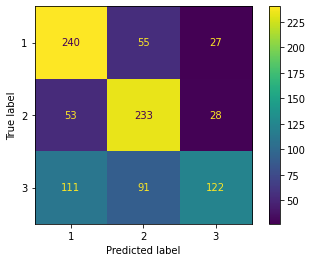


#### results for lowest loss model ####
Accuracy of: 0.6573


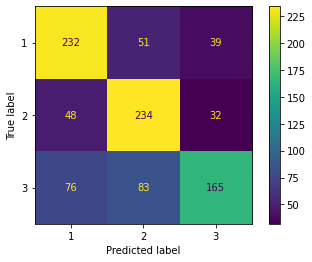


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.9496 @ epoch 977
Best training loss (min) 0.2618 @ epoch 976

Best validation accuracy (max) 0.7474 @ epoch 119
Best validation loss (min) 0.6605 @ epoch 112

#### results for highest accuracy model ####
Accuracy of: 0.6434


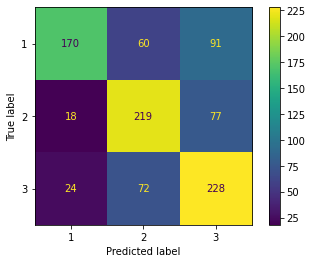


#### results for lowest loss model ####
Accuracy of: 0.5881


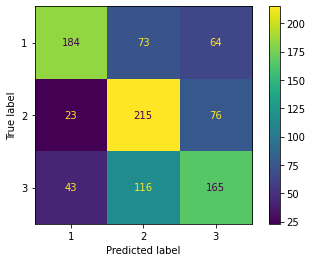


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.9729 @ epoch 960
Best training loss (min) 0.1822 @ epoch 992

Best validation accuracy (max) 0.7332 @ epoch 140
Best validation loss (min) 0.687 @ epoch 140

#### results for highest accuracy model ####
Accuracy of: 0.6649


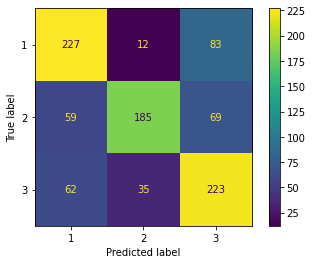


#### results for lowest loss model ####
Accuracy of: 0.6649


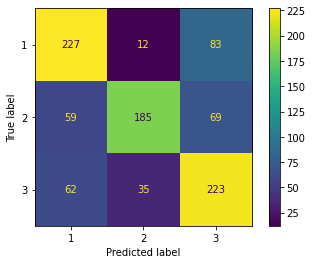

In [12]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/newsubject_longer/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/newsubject_longer/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/newsubject_longer/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## New subject: EEGNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
Perhaps the hardest task is training a classifier on data from one or more subjects, but using it to classify data from a completely new user.
This is the hardest task we'll discuss.
This section will train the same classifiers for the same participants as before but by using one participant for testing and the other two for training.

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use one participant's data for testing and the other two participant's data for training
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen subject not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - lstm_filters = 40
         - lstm_kernel_size = 9
         - ltsm_dropout = 0.7
         - ltsm_l1 = 0.00005
         - ltsm_l2 = 0.00005
      - We trained for 300 epochs due to the increased training time, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set


In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005,
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_id)
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Delete all raws since concat changes them
                    del mne_raws
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
                    
                # Show training data
                print(f"Using data from participants {train_subjects} to train for testing on participant {subject_id}")
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all training data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_newsubject_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 300, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del train_subjects
                del train_subject
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model

#### Results

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.7654 @ epoch 92                    | 0.5768 @ epoch 135               | 0.6469                                           | 0.6479                                            |
| C (Train B&E) | 0.6993 @ epoch 458                   | 0.6921 @ epoch 344               | 0.5892                                           | 0.5996                                            |
| E (Train B&C) | 0.7454 @ epoch 889                   | 0.6425 @ epoch 1196              | 0.6419                                           | 0.6262                                            |

EEGNet with biderectional LSTM conv:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.7497 @ epoch 82                              | 0.6353 @ epoch 47                          | 0.626                                                      | 0.6125                                                      |
| C           | 0.7329 @ epoch 50                              | 0.6575 @ epoch 109                         | 0.6204                                                     | 0.5746                                                      |
| E           | 0.724 @ epoch 240                              | 0.6687 @ epoch 75                          | 0.6136                                                     | 0.6618                                                      |

Test set performance seems slightly better compared to EEGNet, although not by any statistical means.

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_convlstm/newsubject/accuracy.png)
![Loss plot](figures/7/EEGNet_convlstm/newsubject/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset